# **Import Data**

In [ ]:
import pandas as pd
import re

# === 2️⃣ Chargement du dataset ===
file_path = "cybersecurity_dataset.csv"
df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)

print("✅ Dataset chargé avec succès !")
print("Dimensions initiales :", df.shape)
print("Colonnes :", df.columns.tolist())

✅ Dataset chargé avec succès !
Dimensions initiales : (2411, 3)
Colonnes : ['system', 'user', 'assistant']


# **Data Cleaning**

**Import libreries**

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 77.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 84.3 MB/s eta 0:00:00


In [ ]:
import nltk
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec



**Hundle null value**

In [ ]:
# 🧩 3️⃣ Vérification et suppression des valeurs manquantes / doublons
# ============================================================

# Vérifier les valeurs manquantes
print("\n🔍 Valeurs manquantes :")
print(df.isnull().sum())

# Supprimer les lignes où les textes importants sont vides
df.dropna(subset=['user', 'assistant'], inplace=True)

# Supprimer les doublons exacts sur les 3 colonnes
df.drop_duplicates(subset=['system', 'user', 'assistant'], inplace=True)

print("\n✅ Doublons supprimés. Nouvelle taille :", df.shape)


🔍 Valeurs manquantes :
system             0
user               0
assistant          0
system_clean       0
user_clean         0
assistant_clean    0
assistant_nlp      0
dtype: int64

✅ Doublons supprimés. Nouvelle taille : (2408, 7)


**Cleaning Text**

In [ ]:
# ✨ 4️⃣ Nettoyage du texte (ponctuation, chiffres, HTML, espaces)
# ============================================================

def clean_text(text):
    """Nettoie le texte brut : suppression HTML, ponctuation, normalisation."""
    if pd.isnull(text):
        return ""
    text = re.sub(r'<[^>]+>', ' ', text)              # supprimer balises HTML
    text = re.sub(r'[^a-zA-Z0-9\s:/.\-]', ' ', text)  # retirer caractères spéciaux
    text = re.sub(r'\s+', ' ', text)                  # réduire les espaces
    text = text.lower().strip()                       # minuscule et trim
    return text
  # Nettoyage des colonnes textuelles
df['system_clean'] = df['system'].apply(clean_text)
df['user_clean'] = df['user'].apply(clean_text)
df['assistant_clean'] = df['assistant'].apply(clean_text)


In [ ]:
# ============================================================
# 🧮 6️⃣ Filtrage supplémentaire (textes courts, doublons)
# ============================================================

# Supprimer les lignes avec texte trop court (non informatif)
df = df[df['assistant_clean'].str.len() > 10]

# Supprimer les doublons sur le texte nettoyé
df.drop_duplicates(subset=['assistant_clean'], inplace=True)

print("\n📊 Taille finale du dataset :", df.shape)


📊 Taille finale du dataset : (2408, 7)


**Download resources**

In [ ]:
# 🧠 Étape NLP - Prétraitement du texte (adapté cybersécurité)
# ============================================================

# === 1️⃣ Importation des bibliothèques nécessaires ===

# Télécharger les ressources nécessaires (à exécuter une seule fois)
nltk.download('punkt')
nltk.download('punkt_tab')  # ✅ Ajout nécessaire pour les nouvelles versions de NLTK
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Edit StopWords**

In [ ]:
# === 2️⃣ Création d'une liste de stopwords personnalisée ===

# Liste standard de mots vides en anglais
stop_words = set(stopwords.words('english'))

# Liste des termes techniques à CONSERVER (propres à la cybersécurité)
tech_words = [
   'no', 'not', 'nor', 'never', 'none', 'without', "n't",
  'attack', 'attacks', 'malware', 'virus', 'phishing', 'breach',
'exploit', 'vulnerability', 'vulnerabilities', 'threat',
'incident', 'security', 'risk', 'encryption', 'firewall',
'authentication', 'password', 'network', 'data', 'system',
'software', 'hardware', 'server', 'client', 'ransomware',
'sql', 'xss', 'dos', 'ddos', 'access', 'privilege',
'cve', 'mitre', 'nist', 'vuln', 'defense', 'attackers',
'intrusion', 'http', 'https', 'ip', 'get', 'post', 'url',
'csrf', 'ftp', 'dns', 'ssh', 'tcp', 'udp', 'trojan', 'worm',
'cookie', 'request', 'response', 'header', 'token', 'session',
'router'
]

# Extra filler words to remove
extra_fillers = {
    'example', 'etc', 'many', 'various', 'several', 'certain',
    'thing', 'things', 'something', 'anything'
}
custom_stopwords = stop_words.difference(tech_words).union(extra_fillers)


print("✅ Stopwords adaptés à la cybersécurité chargés :", len(stop_words))
print("✅ Stopwords adaptés à la cybersécurité chargés :", len(custom_stopwords))


✅ Stopwords adaptés à la cybersécurité chargés : 198
✅ Stopwords adaptés à la cybersécurité chargés : 205


**Prepating NLP**

In [ ]:
# === 3️⃣ Préparation des outils NLP ===
lemmatizer = WordNetLemmatizer()

# Fonction principale de prétraitement
def preprocess_text(text):
    """
    Effectue :
      - Tokenisation
      - Suppression des stopwords
      - Lemmatisation
    """
    # 1. Tokenisation
    tokens = word_tokenize(text)

    # 2. Filtrer : on garde uniquement les mots alphabétiques non-stopwords
    tokens = [w for w in tokens if w.isalpha() and w not in custom_stopwords]

    # 3. Lemmatisation (retour à la racine des mots)
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    # 4. Reconstruction du texte final
    return " ".join(tokens)


Applicate NLP on assitant_clean

In [ ]:
# === 4️⃣ Application du traitement NLP sur la colonne 'assistant_clean' ===
df['assistant_nlp'] = df['assistant_clean'].apply(preprocess_text)

In [ ]:
# === 5️⃣ Vérification du résultat sur quelques exemples ===
print("\n🔍 Exemple de transformation avant / après :\n")
for i in range(3):
    print("🧾 Texte original :", df['assistant_clean'].iloc[i][:150], "...")
    print("🔹 Texte NLP :", df['assistant_nlp'].iloc[i][:150], "\n")


🔍 Exemple de transformation avant / après :

🧾 Texte original : reflected xss attacks occur when an attacker sends a request containing a malicious script to a vulnerable application that is then returned by the se ...
🔹 Texte NLP : reflected xss attack occur attacker sends request containing malicious script vulnerable application returned server rendered victim browser without p 

🧾 Texte original : the difference between reflected cross-site scripting xss vulnerabilities in a web page versus those in an api endpoint with a content type of applica ...
🔹 Texte NLP : difference reflected scripting xss vulnerability web page versus api endpoint content type primarily due browser interpret render returned data standa 

🧾 Texte original : dom clobbering occurs when an object property name in the document object model dom is overwritten by a malicious property allowing the attacker to by ...
🔹 Texte NLP : dom clobbering occurs object property name document object model dom overwritten mal

**English model setup**

In [ ]:
# Charger le modèle anglais
nlp = spacy.load("en_core_web_sm")


**Linguistic Analysis**

In [ ]:
# --- POS Tagging ---
def extract_pos(text):
    doc = nlp(text)
    return [(token.text, token.pos_) for token in doc]


def extract_ner(text):
    doc = nlp(text)
    # doc.ents contient uniquement les entités reconnues
    return [(ent.text, ent.label_) for ent in doc.ents]


**Display POS Tagging and Named Entity Recognition for the First 5 Texts**

In [ ]:
# Exemple : on prend les 5 premières lignes pour afficher
for i, text in enumerate(df['assistant_clean'].head(5)):
    print(f"\n🔹 Texte original {i+1} :\n{text}\n")

    # POS tagging
    pos_tags = extract_pos(text)
    print("POS Tags :")
    print(pos_tags)

    # NER
    named_entities = extract_ner(text)
    print("Named Entities :")
    print(named_entities)



🔹 Texte original 1 :
reflected xss attacks occur when an attacker sends a request containing a malicious script to a vulnerable application that is then returned by the server and rendered on the victim s browser without proper sanitization. the attack begins with the attacker crafting a url that includes their payload often embedded within query parameters or other user input fields. this crafted url is distributed via email social media or other means to trick users into clicking it. when the victim clicks the link the request is sent to the web server hosting the vulnerable application. the server processes the request but does not adequately filter out malicious content in the inputs. consequently when generating a response such as an error message search results page or dynamic page content the server includes the attacker s payload in the html output. the victim s browser interprets and executes the injected script when rendering the page enabling the attacker to steal session c

**Feature Extraction: Bag-of-Words (BoW) Vectorization**

In [ ]:
# --- Bag-of-Words ---
bow_vectorizer = CountVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    lowercase=True
)
X_bow = bow_vectorizer.fit_transform(df['assistant_nlp'])
# --- Convertir en DataFrame pour voir les mots et leurs comptes ---
bow_df = pd.DataFrame(
    X_bow.toarray(),
    columns=bow_vectorizer.get_feature_names_out()
)



print("✅ Bag-of-Words terminé")
print("Forme de la matrice BoW :", X_bow.shape)

# --- Somme des occurrences de chaque mot dans tout le corpus ---
word_counts = bow_df.sum().sort_values(ascending=False)
print("\n🔹 Top 20 mots les plus fréquents (Bag-of-Words) :")
print(word_counts.head(20))


✅ Bag-of-Words terminé
Forme de la matrice BoW : (2408, 5000)

🔹 Top 20 mots les plus fréquents (Bag-of-Words) :
attacker         7985
attack           6507
security         5591
system           5406
code             4366
vulnerability    4314
data             3946
technique        3938
user             3909
process          3852
like             3752
malicious        3718
application      3365
also             3364
memory           3167
used             3120
using            3074
not              3011
use              2810
exploit          2739
dtype: int64


**Feature Extraction: TF-IDF (Term Frequency–Inverse Document Frequency)**

In [ ]:

# --- TF-IDF ---
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    lowercase=True
)

X_tfidf = tfidf_vectorizer.fit_transform(df['assistant_nlp'])

# --- Convertir en DataFrame pour visualisation ---
tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out()
)

print("✅ TF-IDF terminé")
print("Forme de la matrice TF-IDF :", X_tfidf.shape)

# --- Somme des poids TF-IDF de chaque mot sur tout le corpus ---
tfidf_scores = tfidf_df.sum().sort_values(ascending=False)
print("\n🔹 Top 20 mots les plus importants (TF-IDF) :")
print(tfidf_scores.head(20))


✅ TF-IDF terminé
Forme de la matrice TF-IDF : (2408, 5000)

🔹 Top 20 mots les plus importants (TF-IDF) :
attacker         100.199348
attack            85.525722
system            76.111125
security          72.941948
code              69.822181
vulnerability     68.555159
user              67.024645
memory            64.612937
process           62.384845
application       60.202674
technique         59.485871
data              59.180868
malicious         55.930473
like              53.903625
threat            52.321803
network           51.984234
malware           48.919288
exploit           48.479645
access            48.329736
token             46.761626
dtype: float64


**Visualization Setup: Configure Seaborn Styl**

In [ ]:
sns.set(style="whitegrid")

**Top 20 mots Bag-of-Words**

/tmp/ipython-input-3445622310.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_bow.values, y=top_bow.index, palette="viridis")


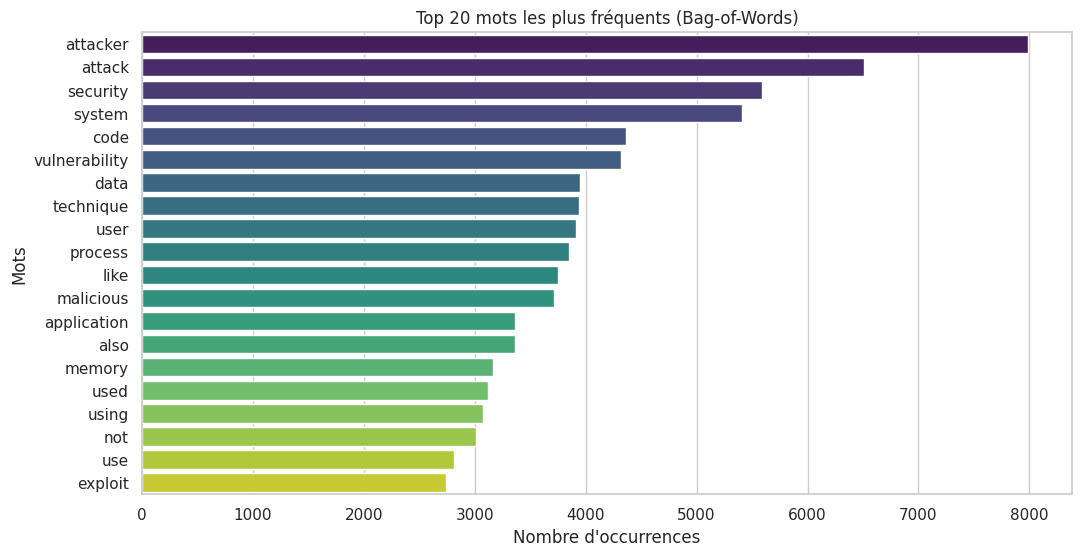

In [ ]:
# --- Top 20 mots Bag-of-Words ---
top_bow = word_counts.head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=top_bow.values, y=top_bow.index, palette="viridis")
plt.title("Top 20 mots les plus fréquents (Bag-of-Words)")
plt.xlabel("Nombre d'occurrences")
plt.ylabel("Mots")
plt.show()


**Top 20 mots TF-IDF**

/tmp/ipython-input-1320819359.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_tfidf.values, y=top_tfidf.index, palette="magma")


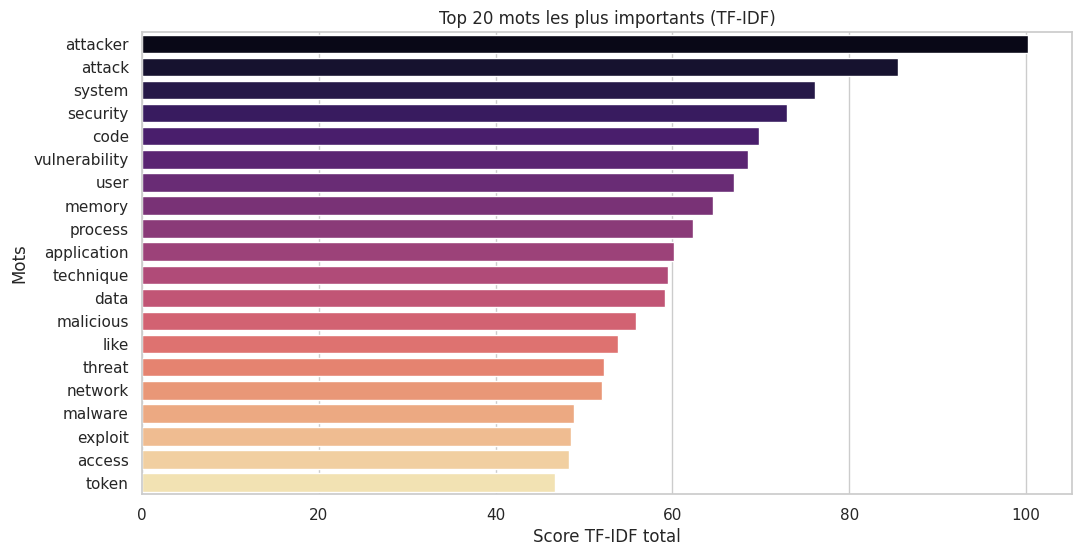

In [ ]:
# --- Top 20 mots TF-IDF ---
top_tfidf = tfidf_scores.head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=top_tfidf.values, y=top_tfidf.index, palette="magma")
plt.title("Top 20 mots les plus importants (TF-IDF)")
plt.xlabel("Score TF-IDF total")
plt.ylabel("Mots")
plt.show()


In [ ]:
df

,system,user,assistant,system_clean,user_clean,assistant_clean,assistant_nlp
0,You are a highly specialized AI assistant for ...,Explain the fundamental data flow of a Reflect...,Reflected XSS attacks occur when an attacker s...,you are a highly specialized ai assistant for ...,explain the fundamental data flow of a reflect...,reflected xss attacks occur when an attacker s...,reflected xss attack occur attacker sends requ...
1,You are a highly specialized AI assistant for ...,How does a Reflected XSS vulnerability in an A...,The difference between reflected cross-site sc...,you are a highly specialized ai assistant for ...,how does a reflected xss vulnerability in an a...,the difference between reflected cross-site sc...,difference reflected scripting xss vulnerabili...
2,You are a highly specialized AI assistant for ...,"What is \""DOM Clobbering\"" and how can it be u...",DOM Clobbering occurs when an object property ...,you are a highly specialized ai assistant for ...,what is dom clobbering and how can it be used ...,dom clobbering occurs when an object property ...,dom clobbering occurs object property name doc...
3,You are a highly specialized AI assistant for ...,"Explain the concept of \""filter evasion\"" in t...",XSS attacks are the most dangerous vulnerabili...,you are a highly specialized ai assistant for ...,explain the concept of filter evasion in the c...,xss attacks are the most dangerous vulnerabili...,xss attack dangerous vulnerability web applica...
4,You are a highly specialized AI assistant for ...,"How can character encoding (e.g., UTF-7, UTF-1...",This is the first time I will be teaching a cl...,you are a highly specialized ai assistant for ...,how can character encoding e.g. utf-7 utf-16 c...,this is the first time i will be teaching a cl...,first time teaching class career cybersecurity...
...,...,...,...,...,...,...,...
2406,You are a highly specialized AI assistant for ...,How can researchers design hardware implants t...,The creation of hardware implants capable of e...,you are a highly specialized ai assistant for ...,how can researchers design hardware implants t...,the creation of hardware implants capable of e...,creation hardware implant capable establishing...
2407,You are a highly specialized AI assistant for ...,What is the modulation scheme selection proces...,The modulation scheme selection is a key desig...,you are a highly specialized ai assistant for ...,what is the modulation scheme selection proces...,the modulation scheme selection is a key desig...,modulation scheme selection key design decisio...
2408,You are a highly specialized AI assistant for ...,How does one construct miniaturized PLC implan...,The most effective way to create an implant in...,you are a highly specialized ai assistant for ...,how does one construct miniaturized plc implan...,the most effective way to create an implant in...,effective way create implant plc embed existin...
2409,You are a highly specialized AI assistant for ...,What are the techniques for implementing sprea...,Spread spectrum modulation techniques can be u...,you are a highly specialized ai assistant for ...,what are the techniques for implementing sprea...,spread spectrum modulation techniques can be u...,spread spectrum modulation technique used modu...


# **Tokanization**

In [ ]:
# --- Ensure required NLTK resources are available ---
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt', quiet=True)

# --- Apply tokenization to your dataset ---
# This uses your existing `custom_stopwords` from the notebook

df["tokens"] = df["user_clean"].apply(
    lambda x: [
        tok.lower() for tok in word_tokenize(str(x))
        if tok.isalnum() and tok.lower() not in custom_stopwords
    ]
)

print("✅ Tokenization complete. Sample tokens:")
print(df[["user_clean", "tokens"]].head())


✅ Tokenization complete. Sample tokens:
                                          user_clean  \
0  explain the fundamental data flow of a reflect...   
1  how does a reflected xss vulnerability in an a...   
2  what is dom clobbering and how can it be used ...   
3  explain the concept of filter evasion in the c...   
4  how can character encoding e.g. utf-7 utf-16 c...   

                                              tokens  
0  [explain, fundamental, data, flow, reflected, ...  
1  [reflected, xss, vulnerability, api, endpoint,...  
2  [dom, clobbering, used, escalate, enable, refl...  
3  [explain, concept, filter, evasion, context, r...  
4  [character, encoding, abused, bypass, xss, fil...  


In [ ]:
df

,system,user,assistant,system_clean,user_clean,assistant_clean,assistant_nlp,tokens
0,You are a highly specialized AI assistant for ...,Explain the fundamental data flow of a Reflect...,Reflected XSS attacks occur when an attacker s...,you are a highly specialized ai assistant for ...,explain the fundamental data flow of a reflect...,reflected xss attacks occur when an attacker s...,reflected xss attack occur attacker sends requ...,"[explain, fundamental, data, flow, reflected, ..."
1,You are a highly specialized AI assistant for ...,How does a Reflected XSS vulnerability in an A...,The difference between reflected cross-site sc...,you are a highly specialized ai assistant for ...,how does a reflected xss vulnerability in an a...,the difference between reflected cross-site sc...,difference reflected scripting xss vulnerabili...,"[reflected, xss, vulnerability, api, endpoint,..."
2,You are a highly specialized AI assistant for ...,"What is \""DOM Clobbering\"" and how can it be u...",DOM Clobbering occurs when an object property ...,you are a highly specialized ai assistant for ...,what is dom clobbering and how can it be used ...,dom clobbering occurs when an object property ...,dom clobbering occurs object property name doc...,"[dom, clobbering, used, escalate, enable, refl..."
3,You are a highly specialized AI assistant for ...,"Explain the concept of \""filter evasion\"" in t...",XSS attacks are the most dangerous vulnerabili...,you are a highly specialized ai assistant for ...,explain the concept of filter evasion in the c...,xss attacks are the most dangerous vulnerabili...,xss attack dangerous vulnerability web applica...,"[explain, concept, filter, evasion, context, r..."
4,You are a highly specialized AI assistant for ...,"How can character encoding (e.g., UTF-7, UTF-1...",This is the first time I will be teaching a cl...,you are a highly specialized ai assistant for ...,how can character encoding e.g. utf-7 utf-16 c...,this is the first time i will be teaching a cl...,first time teaching class career cybersecurity...,"[character, encoding, abused, bypass, xss, fil..."
...,...,...,...,...,...,...,...,...
2406,You are a highly specialized AI assistant for ...,How can researchers design hardware implants t...,The creation of hardware implants capable of e...,you are a highly specialized ai assistant for ...,how can researchers design hardware implants t...,the creation of hardware implants capable of e...,creation hardware implant capable establishing...,"[researchers, design, hardware, implants, esta..."
2407,You are a highly specialized AI assistant for ...,What is the modulation scheme selection proces...,The modulation scheme selection is a key desig...,you are a highly specialized ai assistant for ...,what is the modulation scheme selection proces...,the modulation scheme selection is a key desig...,modulation scheme selection key design decisio...,"[modulation, scheme, selection, process, imple..."
2408,You are a highly specialized AI assistant for ...,How does one construct miniaturized PLC implan...,The most effective way to create an implant in...,you are a highly specialized ai assistant for ...,how does one construct miniaturized plc implan...,the most effective way to create an implant in...,effective way create implant plc embed existin...,"[one, construct, miniaturized, plc, implants, ..."
2409,You are a highly specialized AI assistant for ...,What are the techniques for implementing sprea...,Spread spectrum modulation techniques can be u...,you are a highly specialized ai assistant for ...,what are the techniques for implementing sprea...,spread spectrum modulation techniques can be u...,spread spectrum modulation technique used modu...,"[techniques, implementing, spread, spectrum, p..."


**Visualization of Frequent Words in User Texts (WordCloud for Cybersecurity Incidents)**


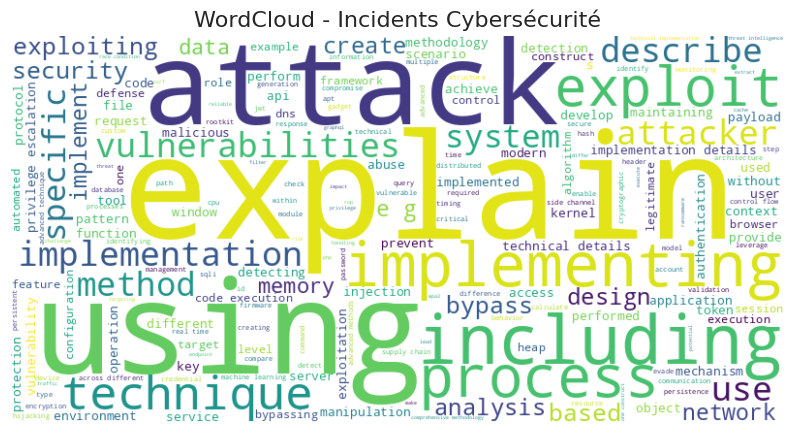

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Toujours nettoyer les valeurs nulles/NaN avant de joindre le texte
all_text = " ".join(df['user_clean'].fillna('').astype(str).tolist())

# Création et affichage du WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Incidents Cybersécurité', fontsize=16)
plt.show()


**CLASSIFICATION BINAIRE : "Attaque" vs "Non Attaque"**



🔖 Répartition des classes :
label
1    1837
0     571
Name: count, dtype: int64
📊 Taille des ensembles :
Train : (1926, 5000) Test : (482, 5000)

✅ Accuracy : 0.82

📈 Rapport de classification :
               precision    recall  f1-score   support

           0       0.59      0.80      0.68       114
           1       0.93      0.83      0.87       368

    accuracy                           0.82       482
   macro avg       0.76      0.81      0.78       482
weighted avg       0.85      0.82      0.83       482


🧾 Matrice de confusion :
 [[ 91  23]
 [ 64 304]]


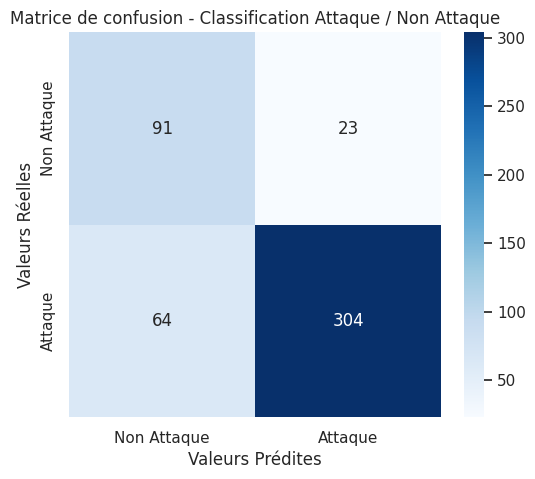

In [ ]:
# ============================================================
# 🧠 7️⃣ CLASSIFICATION BINAIRE : "Attaque" vs "Non Attaque"
# ============================================================

import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# 1️⃣ Création des étiquettes (labels)
# ------------------------------------------------------------

def detect_attack(text):
    """
    Détermine si un texte parle d'une attaque (1) ou non (0).
    Les textes de défense, prévention, analyse, etc. sont considérés comme 'non attaque'.
    """
    if isinstance(text, str) and re.search(r'\b(attack|malware|phishing|virus|exploit|ddos|breach|ransomware)\b', text, re.IGNORECASE):
        return 1  # Attaque
    else:
        return 0  # Non-attaque

# Application de la fonction sur la colonne textuelle nettoyée
df['label'] = df['assistant_clean'].apply(detect_attack)

print("🔖 Répartition des classes :")
print(df['label'].value_counts())

# ------------------------------------------------------------
# 2️⃣ Préparation des données (features et labels)
# ------------------------------------------------------------
X = X_tfidf             # La matrice TF-IDF calculée précédemment
y = df['label']          # Les étiquettes binaires (0 = non-attaque, 1 = attaque)

# ------------------------------------------------------------
# 3️⃣ Division en jeu d'entraînement et de test
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("📊 Taille des ensembles :")
print("Train :", X_train.shape, "Test :", X_test.shape)

# ------------------------------------------------------------
# 4️⃣ Entraînement du modèle
# ------------------------------------------------------------
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train, y_train)


# ------------------------------------------------------------
# 5️⃣ Évaluation du modèle
# ------------------------------------------------------------
y_pred = clf.predict(X_test)

print("\n✅ Accuracy :", round(accuracy_score(y_test, y_pred), 3))
print("\n📈 Rapport de classification :\n", classification_report(y_test, y_pred))
print("\n🧾 Matrice de confusion :\n", confusion_matrix(y_test, y_pred))

# ------------------------------------------------------------
# 6️⃣ Visualisation de la matrice de confusion
# ------------------------------------------------------------
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non Attaque', 'Attaque'],
            yticklabels=['Non Attaque', 'Attaque'])
plt.title("Matrice de confusion - Classification Attaque / Non Attaque")
plt.xlabel("Valeurs Prédites")
plt.ylabel("Valeurs Réelles")
plt.show()


# **SBERT**

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Check if the 'embedding_sbert' column exists
if 'embedding_sbert' in df.columns:
    # Extract SBERT embeddings
    X_sbert = np.array(df['embedding_sbert'].tolist())

    # Use the optimal number of clusters found previously for TF-IDF clustering
    # If you skipped the Elbow method for TF-IDF, you might want to run it here for SBERT
    # For now, we reuse the number found for TF-IDF (optimal_n_clusters)
    n_clusters_sbert = optimal_n_clusters # Reusing the variable from TF-IDF clustering step

    print(f"Applying K-Means clustering with {n_clusters_sbert} clusters using SBERT embeddings.")

    # Instantiate and fit KMeans model
    kmeans_sbert = KMeans(n_clusters=n_clusters_sbert, random_state=42, n_init=10)
    df['sbert_cluster'] = kmeans_sbert.fit_predict(X_sbert)

    # Print cluster distribution
    print("\nDistribution of clusters based on SBERT embeddings:")
    print(df['sbert_cluster'].value_counts())

    # Optionally, print example texts for each cluster
    print("\nExample texts for each SBERT cluster:")
    for cluster_id in range(n_clusters_sbert):
        print(f"\nCluster {cluster_id}:")
        # Get up to 3 examples from this cluster
        examples = df[df['sbert_cluster'] == cluster_id]['user_clean'].head(3).tolist()
        for example in examples:
            print(f"- {example[:150]}...") # Print first 150 characters

else:
    print("The 'embedding_sbert' column is missing. Please ensure SBERT embeddings are generated before running this step.")


The 'embedding_sbert' column is missing. Please ensure SBERT embeddings are generated before running this step.


**Text Representation with SBERT and Topic Discovery via K-Means**

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.cluster import KMeans


# Load a Sentence-Transformer model
try:
    # Using the previously defined model name if available, otherwise use a default
    sbert_model_name = args.sbert_model if 'args' in locals() and args.sbert_model else 'all-MiniLM-L6-v2'
    model_sbert = SentenceTransformer(sbert_model_name)
    print(f"Sentence-Transformer model '{sbert_model_name}' loaded successfully.")
except Exception as e:
    print(f"Error loading Sentence-Transformer model: {e}")
    model_sbert = None


if model_sbert and 'user_clean' in df.columns:
    # Generate SBERT embeddings
    print("\nGenerating SBERT embeddings...")
    # Ensure 'processed_text' is treated as string and handle potential NaNs
    df['embedding_sbert'] = df['user_clean'].fillna('').astype(str).apply(lambda x: model_sbert.encode(x))
    print("SBERT embeddings generated.")

    # Display first 10 values of the first embedding
    if not df.empty and 'embedding_sbert' in df.columns and len(df['embedding_sbert'].iloc[0]) > 0:
         print("SBERT Embedding (first 10 values):", df['embedding_sbert'].iloc[0][:10])
    else:
        print("Could not display SBERT embedding.")

    # Now apply K-Means clustering on the generated SBERT embeddings
    print("\nApplying K-Means clustering on SBERT embeddings...")
    X_sbert = np.array(df['embedding_sbert'].tolist())

    # Use the optimal number of clusters found previously for TF-IDF clustering
    # If optimal_n_clusters is not defined, set a default
    n_clusters_sbert = optimal_n_clusters if 'optimal_n_clusters' in locals() else 8 # Default to 8 if not defined

    print(f"Using {n_clusters_sbert} clusters for K-Means on SBERT embeddings.")

    # Instantiate and fit KMeans model
    kmeans_sbert = KMeans(n_clusters=n_clusters_sbert, random_state=42, n_init=10)
    df['sbert_cluster'] = kmeans_sbert.fit_predict(X_sbert)

    # Print cluster distribution
    print("\nDistribution of clusters based on SBERT embeddings:")
    print(df['sbert_cluster'].value_counts())

    # Optionally, print example texts for each cluster
    print("\nExample texts for each SBERT cluster:")
    for cluster_id in range(n_clusters_sbert):
        print(f"\nCluster {cluster_id}:")
        # Get up to 3 examples from this cluster
        examples = df[df['sbert_cluster'] == cluster_id]['user_clean'].head(3).tolist()
        for example in examples:
            print(f"- {example[:150]}...") # Print first 150 characters


else:
    print("\nCould not generate SBERT embeddings or 'processed_text' column is missing. Cannot proceed with clustering.")

Sentence-Transformer model 'all-MiniLM-L6-v2' loaded successfully.

Generating SBERT embeddings...
SBERT embeddings generated.
SBERT Embedding (first 10 values): [-0.03212602  0.01534216  0.01314587 -0.01063393  0.05395245 -0.06509253
  0.09597042 -0.00571863  0.00109673 -0.01965994]

Applying K-Means clustering on SBERT embeddings...
Using 8 clusters for K-Means on SBERT embeddings.

Distribution of clusters based on SBERT embeddings:
sbert_cluster
5    419
7    388
0    375
6    314
1    271
2    248
4    246
3    147
Name: count, dtype: int64

Example texts for each SBERT cluster:

Cluster 0:
- how can an lfi vulnerability be used to cause a denial of service dos provide an example of a file on a linux system that when included would hang or ...
- what is the expect:// wrapper explain how if the expect extension is installed an attacker can use it to execute arbitrary shell commands directly via...
- how would you use lfi to access file descriptors available to the running web serve

**Exemple**

In [ ]:
# Print example texts for each SBERT cluster, handling potential non-string types
print("\nExample texts for each SBERT cluster (with error handling):")
for cluster_id in range(n_clusters_sbert):
    print(f"\nCluster {cluster_id}:")
    # Get up to 3 examples from this cluster
    examples = df[df['sbert_cluster'] == cluster_id]['user_clean'].head(3).tolist()
    for example in examples:
        if isinstance(example, str):
            print(f"- {example[:150]}...") # Print first 150 characters of string examples
        else:
            print(f"- (Non-string example: {example})...") # Indicate non-string examples



Example texts for each SBERT cluster (with error handling):

Cluster 0:
- how can an lfi vulnerability be used to cause a denial of service dos provide an example of a file on a linux system that when included would hang or ...
- what is the expect:// wrapper explain how if the expect extension is installed an attacker can use it to execute arbitrary shell commands directly via...
- how would you use lfi to access file descriptors available to the running web server process which wrapper or pseudo-filesystem /proc/self/fd/... woul...

Cluster 1:
- how can an attacker use different number bases e.g. hexadecimal 0x... or string concatenation functions to obfuscate a payload and evade filters...
- describe how an attacker can use lfi to enumerate running processes and discover sensitive information on a linux server. which pseudo-filesystem woul...
- describe a methodology for manually discovering and confirming an insecure deserialization vulnerability. your answer should cover identify

In [ ]:
# Examine the content of each SBERT cluster
print("\nExamining SBERT Cluster Content:")
for cluster_id in sorted(df['sbert_cluster'].unique()):
    print(f"\n--- Cluster {cluster_id} ---")
    cluster_texts = df[df['sbert_cluster'] == cluster_id]['user_clean'].fillna('').astype(str).tolist()
    print(f"Number of documents in cluster: {len(cluster_texts)}")

    # Print a sample of texts from the cluster
    print("Sample texts:")
    for i, text in enumerate(cluster_texts[:5]): # Print first 5 texts
        print(f"{i+1}. {text[:200]}...") # Print first 200 characters

    # Optional: Could add keyword extraction here if needed
    # from keybert import KeyBERT
    # kw_model = KeyBERT()
    # keywords = kw_model.extract_keywords(" ".join(cluster_texts), keyphrase_ngram_range=(1, 2), stop_words='english', top_n=10)
    # print("Top keywords:", keywords)



Examining SBERT Cluster Content:

--- Cluster 0 ---
Number of documents in cluster: 375
Sample texts:
1. how can an lfi vulnerability be used to cause a denial of service dos provide an example of a file on a linux system that when included would hang or crash the application....
2. what is the expect:// wrapper explain how if the expect extension is installed an attacker can use it to execute arbitrary shell commands directly via an lfi vulnerability....
3. how would you use lfi to access file descriptors available to the running web server process which wrapper or pseudo-filesystem /proc/self/fd/... would you use and what might you find...
4. what is a command injection vulnerability provide a scenario where an api endpoint that interacts with an underlying system command could be exploited....
5. how do apts achieve and maintain persistence describe three distinct persistence mechanisms on a windows system ranging from simple e.g. a scheduled task to advanced e.g. a wmi event subsc

**Number of cclusters and exemple**

In [ ]:
# Continue examining the content of the remaining SBERT clusters
print(f"\n--- Cluster 4 ---")
cluster_texts = df[df['sbert_cluster'] == 4]['user_clean'].fillna('').astype(str).tolist()
print(f"Number of documents in cluster: {len(cluster_texts)}")

# Print a sample of texts from the cluster
print("Sample texts:")
for i, text in enumerate(cluster_texts[:5]): # Print first 5 texts
    print(f"{i+1}. {text[:200]}...") # Print first 200 characters

print(f"\n--- Cluster 5 ---")
cluster_texts = df[df['sbert_cluster'] == 5]['user_clean'].fillna('').astype(str).tolist()
print(f"Number of documents in cluster: {len(cluster_texts)}")

# Print a sample of texts from the cluster
print("Sample texts:")
for i, text in enumerate(cluster_texts[:5]): # Print first 5 texts
    print(f"{i+1}. {text[:200]}...") # Print first 200 characters

print(f"\n--- Cluster 6 ---")
cluster_texts = df[df['sbert_cluster'] == 6]['user_clean'].fillna('').astype(str).tolist()
print(f"Number of documents in cluster: {len(cluster_texts)}")

# Print a sample of texts from the cluster
print("Sample texts:")
for i, text in enumerate(cluster_texts[:5]): # Print first 5 texts
    print(f"{i+1}. {text[:200]}...") # Print first 200 characters

print(f"\n--- Cluster 7 ---")
cluster_texts = df[df['sbert_cluster'] == 7]['user_clean'].fillna('').astype(str).tolist()
print(f"Number of documents in cluster: {len(cluster_texts)}")

# Print a sample of texts from the cluster
print("Sample texts:")
for i, text in enumerate(cluster_texts[:5]): # Print first 5 texts
    print(f"{i+1}. {text[:200]}...") # Print first 200 characters



--- Cluster 4 ---
Number of documents in cluster: 246
Sample texts:
1. explain the synchronizer token pattern in detail. describe the lifecycle of a stateful server-side anti-csrf token from generation to validation. what are the essential security properties this token ...
2. compare the double submit cookie pattern with the synchronizer token pattern. what are the primary advantages e.g. statelessness and disadvantages e.g. security weaknesses of the double submit cookie ...
3. imagine an application that allows changing a user s email address via a post request but requires the user s current password for confirmation. how does this design feature mitigate the risk of a sim...
4. explain how the saml security assertion markup language authentication protocol can be vulnerable to xxe. what is the potential impact of a successful xxe attack against a saml identity provider or se...
5. in a microservices architecture where data ownership and authorization logic might be distributed ac

# Asign names

In [ ]:
# Assign a label to each SBERT cluster based on the analysis of example texts and common themes
sbert_cluster_labels_map = {
    0: "Web App Vulns (XSS, SQLi, Incident Response)",
    1: "Auth, Authz, Access Control & Related Tech",
    2: "Reflected XSS Techniques & WAF Bypass",
    3: "SSTI & Deserialization Vulns",
    4: "SQL Injection & Stored XSS Techniques",
    5: "Post-Exploitation & Lateral Movement (Windows LOTL)",
    6: "Advanced/Low-Level Attacks (Hardware, Rootkits, MITM)",
    7: "Network & Communication Security (TLS, Microservices)"
}

# Map the cluster IDs to the new labels
df['sbert_cluster_label'] = df['sbert_cluster'].map(sbert_cluster_labels_map)

print("DataFrame with SBERT Cluster Labels:")
display(df[['user_clean', 'sbert_cluster', 'sbert_cluster_label']].head())

print("\nDistribution of SBERT Cluster Labels:")
print(df['sbert_cluster_label'].value_counts())

DataFrame with SBERT Cluster Labels:


,user_clean,sbert_cluster,sbert_cluster_label
0,explain the fundamental data flow of a reflect...,3,SSTI & Deserialization Vulns
1,how does a reflected xss vulnerability in an a...,3,SSTI & Deserialization Vulns
2,what is dom clobbering and how can it be used ...,3,SSTI & Deserialization Vulns
3,explain the concept of filter evasion in the c...,3,SSTI & Deserialization Vulns
4,how can character encoding e.g. utf-7 utf-16 c...,3,SSTI & Deserialization Vulns



Distribution of SBERT Cluster Labels:
sbert_cluster_label
Post-Exploitation & Lateral Movement (Windows LOTL)      419
Network & Communication Security (TLS, Microservices)    388
Web App Vulns (XSS, SQLi, Incident Response)             375
Advanced/Low-Level Attacks (Hardware, Rootkits, MITM)    314
Auth, Authz, Access Control & Related Tech               271
Reflected XSS Techniques & WAF Bypass                    248
SQL Injection & Stored XSS Techniques                    246
SSTI & Deserialization Vulns                             147
Name: count, dtype: int64


In [ ]:
!pip install keybert torch torch_geometric

In [ ]:
print(df.columns)

Index(['system', 'user', 'assistant', 'system_clean', 'user_clean',
       'assistant_clean', 'assistant_nlp', 'tokens', 'label',
       'embedding_sbert', 'sbert_cluster', 'sbert_cluster_label'],
      dtype='object')


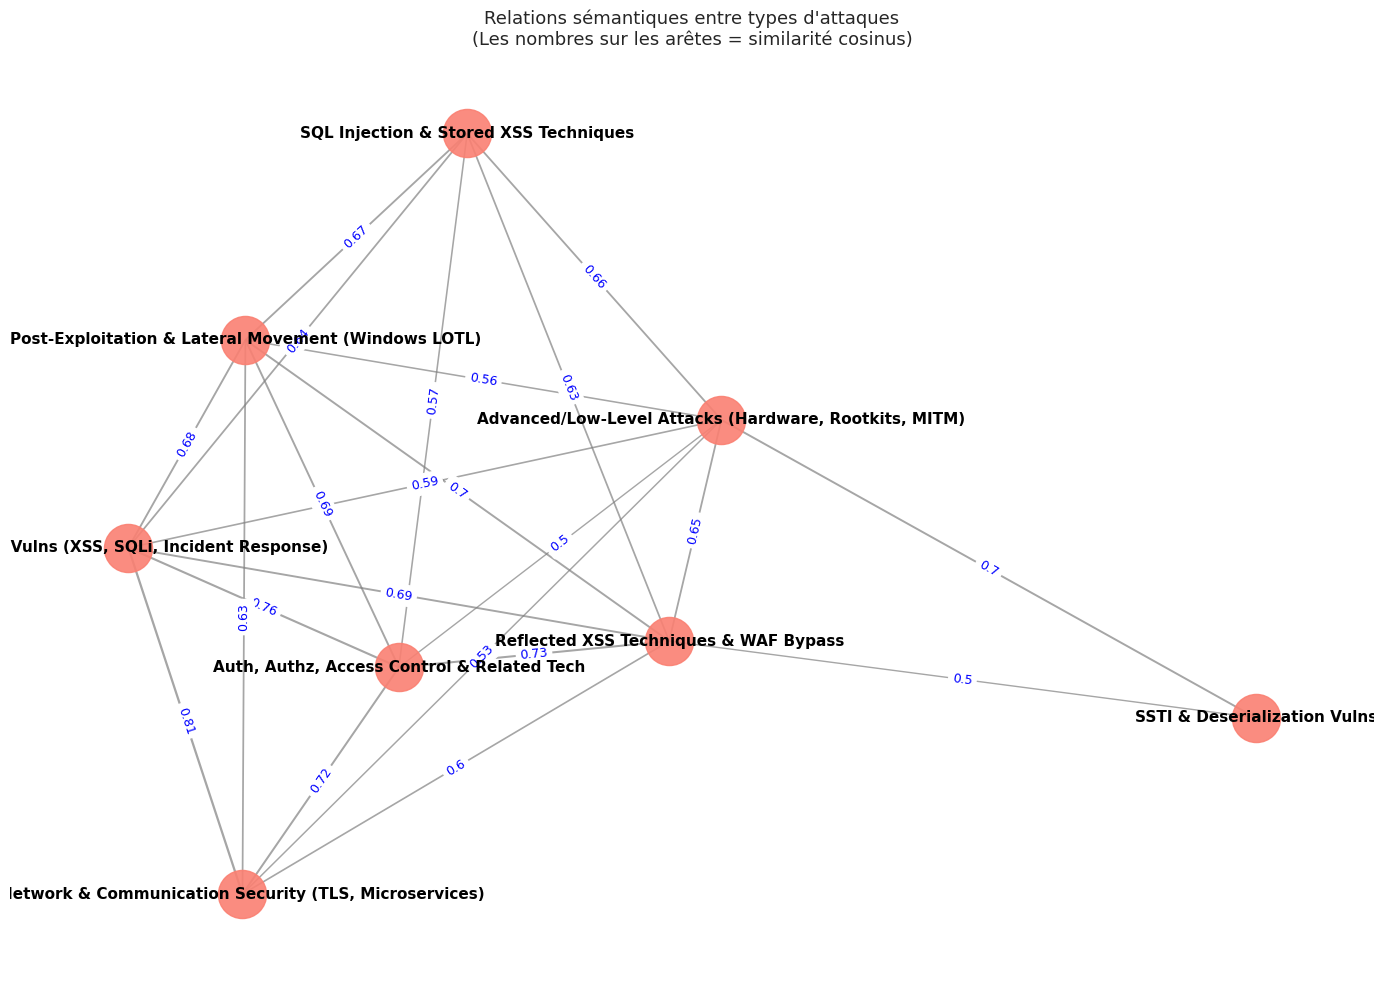


🔗 Relations avec similarité :

✅ 'Advanced/Low-Level Attacks (Hardware, Rootkits, MITM)' —— 0.5 —— 'Auth, Authz, Access Control & Related Tech'
✅ 'Advanced/Low-Level Attacks (Hardware, Rootkits, MITM)' —— 0.5299999713897705 —— 'Network & Communication Security (TLS, Microservices)'
✅ 'Advanced/Low-Level Attacks (Hardware, Rootkits, MITM)' —— 0.5600000023841858 —— 'Post-Exploitation & Lateral Movement (Windows LOTL)'
✅ 'Advanced/Low-Level Attacks (Hardware, Rootkits, MITM)' —— 0.6499999761581421 —— 'Reflected XSS Techniques & WAF Bypass'
✅ 'Advanced/Low-Level Attacks (Hardware, Rootkits, MITM)' —— 0.6600000262260437 —— 'SQL Injection & Stored XSS Techniques'
✅ 'Advanced/Low-Level Attacks (Hardware, Rootkits, MITM)' —— 0.699999988079071 —— 'SSTI & Deserialization Vulns'
✅ 'Advanced/Low-Level Attacks (Hardware, Rootkits, MITM)' —— 0.5899999737739563 —— 'Web App Vulns (XSS, SQLi, Incident Response)'
✅ 'Auth, Authz, Access Control & Related Tech' —— 0.7200000286102295 —— 'Network & Communi

In [ ]:
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# --- ÉTAPE 1 : Préparer les embeddings moyens par cluster (robuste) ---
df_clean = df.dropna(subset=['sbert_cluster_label', 'embedding_sbert']).copy()

def to_tensor(emb):
    if isinstance(emb, torch.Tensor):
        return emb.float()
    elif isinstance(emb, np.ndarray):
        return torch.tensor(emb, dtype=torch.float)
    elif isinstance(emb, list):
        return torch.tensor(emb, dtype=torch.float)
    else:
        try:
            import ast
            return torch.tensor(ast.literal_eval(emb), dtype=torch.float)
        except:
            return None

df_clean['emb_tensor'] = df_clean['embedding_sbert'].apply(to_tensor)
df_clean = df_clean[df_clean['emb_tensor'].notnull()]

if df_clean.empty:
    raise ValueError("Aucun embedding valide trouvé.")

# Vérifier la dimension
D = df_clean['emb_tensor'].iloc[0].shape[0]
df_clean = df_clean[df_clean['emb_tensor'].apply(lambda x: x.shape[0] == D)]

# Moyenne par cluster
cluster_groups = df_clean.groupby('sbert_cluster_label')['emb_tensor']
attack_labels = []
mean_embeddings = []

for label, group in cluster_groups:
    mean_emb = torch.stack(list(group)).mean(dim=0).numpy()
    attack_labels.append(label)
    mean_embeddings.append(mean_emb)

mean_embeddings = np.array(mean_embeddings)

# --- ÉTAPE 2 : Créer le graphe avec similarité ---
if len(attack_labels) == 1:
    print(f"⚠️ Un seul type d'attaque : '{attack_labels[0]}' → pas de relations possibles.")
    G = nx.Graph()
    G.add_node(attack_labels[0])
else:
    sim_matrix = cosine_similarity(mean_embeddings)
    G = nx.Graph()

    # Ajouter les nœuds
    for label in attack_labels:
        G.add_node(label)

    # Ajouter les arêtes avec similarité (seuil = 0.5)
    threshold = 0.5
    for i in range(len(attack_labels)):
        for j in range(i + 1, len(attack_labels)):
            sim = sim_matrix[i, j]
            if sim > threshold:
                # Arrondir à 2 décimales pour lisibilité
                G.add_edge(attack_labels[i], attack_labels[j], weight=sim, similarity=round(sim, 2))

# --- ÉTAPE 3 : Visualiser avec labels sur les arêtes ---
plt.figure(figsize=(14, 10))

if len(G.nodes) == 1:
    pos = {list(G.nodes)[0]: (0, 0)}
else:
    pos = nx.spring_layout(G, k=1.2, seed=42, iterations=50)

# Nœuds
nx.draw_networkx_nodes(G, pos, node_color='salmon', node_size=1200, alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold', font_color='black')

# Arêtes
edge_weights = [G[u][v]['similarity'] * 2 for u, v in G.edges()]  # épaisseur proportionnelle
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.7, edge_color='gray')

# 🔑 AJOUT : Labels sur les arêtes
edge_labels = nx.get_edge_attributes(G, 'similarity')
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_size=9,
    font_color='blue'
)

plt.title("Relations sémantiques entre types d'attaques\n(Les nombres sur les arêtes = similarité cosinus)", fontsize=13)
plt.axis('off')
plt.tight_layout()
plt.show()

# --- ÉTAPE 4 : Afficher les relations dans la console ---
if len(attack_labels) > 1:
    print("\n🔗 Relations avec similarité :\n")
    for u, v, data in G.edges(data=True):
        print(f"✅ '{u}' —— {data['similarity']} —— '{v}'")
else:
    print(f"\n⚠️ Un seul type d'attaque détecté : '{attack_labels[0]}'")

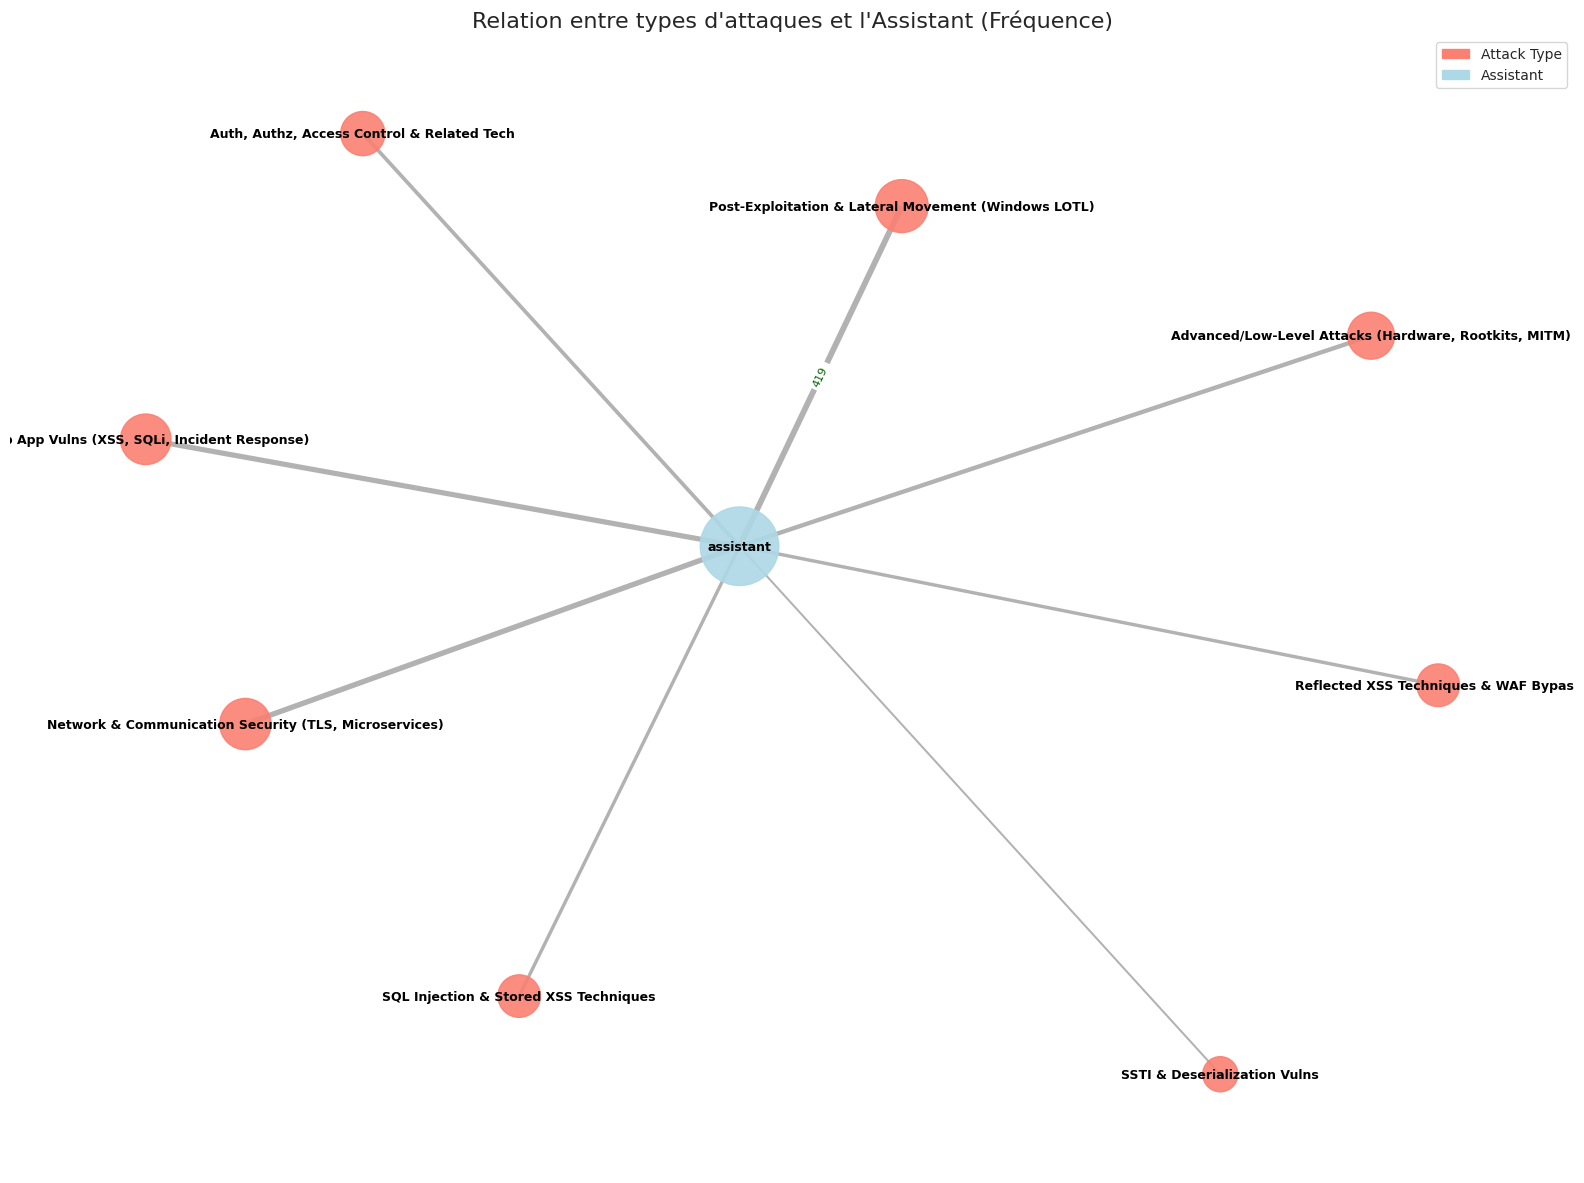

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

# Define colors for different node types
node_colors = {'assistant': 'lightblue'}

# Populate graph with attack types and counts, and connect to 'assistant'
counts = df['sbert_cluster_label'].value_counts()
for attack, count in counts.items():
    G.add_node(attack, size=count, color='salmon') # Attacks are salmon
    G.add_edge(attack, "assistant", weight=count)
    node_colors[attack] = 'salmon'

# Add the 'assistant' node
G.add_node("assistant", color='lightblue', size=1000) # Assistant is lightblue, with a base size

# Prepare for drawing
plt.figure(figsize=(16, 12))  # Increase figure size for better readability

# Use spring layout for better node distribution
pos = nx.spring_layout(G, k=0.7, iterations=50, seed=42) # Adjust k and iterations for spacing

# Get node sizes and colors dynamically
node_sizes = [200 + G.nodes[n].get('size', 1) * 3 for n in G.nodes()]
colors = [G.nodes[n]['color'] for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold', font_color='black')

# Draw edges and add edge labels for weights
edges = G.edges(data=True)
edge_weights = [d['weight'] / 100 for u, v, d in edges] # Scale weights for better visual width
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.6, edge_color='gray')

# Add edge labels (counts) for 'attack' -> 'assistant' relations
edge_labels = {(u, v): d['weight'] for u, v, d in edges if v == 'assistant'}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='darkgreen', font_size=8)

# Create a legend
import matplotlib.patches as mpatches
attack_patch = mpatches.Patch(color='salmon', label='Attack Type')
assistant_patch = mpatches.Patch(color='lightblue', label='Assistant')
plt.legend(handles=[attack_patch, assistant_patch], loc='upper right', fontsize=10)

plt.title("Relation entre types d'attaques et l'Assistant (Fréquence)", fontsize=16)
plt.axis('off') # Hide axes
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()


In [ ]:
from sentence_transformers import SentenceTransformer

# Charger le modèle SBERT (utilise le même que celui d'origine si possible)
print("🔄 Encodage des messages utilisateur avec Sentence-BERT...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')  # ou 'all-mpnet-base-v2'

# Nettoyer les NaN dans user_clean
df_clean = df.dropna(subset=['sbert_cluster_label', 'user_clean']).copy()
print(f"✅ {len(df_clean)} lignes valides après nettoyage.")

# Encoder les messages
embeddings = sbert_model.encode(
    df_clean['user_clean'].tolist(),
    convert_to_tensor=False,  # on garde en numpy pour compatibilité
    show_progress_bar=True
)

# Ajouter au DataFrame
df_clean['user_emb'] = [torch.tensor(emb, dtype=torch.float) for emb in embeddings]

# Vérifier
print("✅ Embeddings générés :", len(df_clean))
if len(df_clean) == 0:
    raise ValueError("Échec : aucun embedding généré.")

🔄 Encodage des messages utilisateur avec Sentence-BERT...
✅ 2408 lignes valides après nettoyage.


Batches:   0%|          | 0/76 [00:00<?, ?it/s]

✅ Embeddings générés : 2408


In [ ]:
# Mapping attack_type
attack_labels = df_clean['sbert_cluster_label'].unique()
attack_to_id = {label: i for i, label in enumerate(attack_labels)}

N = len(df_clean)
C = len(attack_labels)
D = df_clean['user_emb'].iloc[0].shape[0]  # ✅ maintenant sécurisé

# ... suite du code (assistant_msg, HeteroData, etc.)

In [ ]:
# 1. Vérifie que 'assistant_clean' existe et est propre
df_clean = df_clean.dropna(subset=['assistant_clean']).copy()
print(f"✅ {len(df_clean)} réponses valides dans 'assistant_clean'")

# 2. Encode les réponses avec Sentence-BERT
from sentence_transformers import SentenceTransformer
sbert = SentenceTransformer('all-MiniLM-L6-v2')

print("🔄 Encodage des réponses de l'assistant...")
assistant_embeddings = sbert.encode(
    df_clean['assistant_clean'].tolist(),
    convert_to_tensor=False,  # retourne des arrays numpy
    show_progress_bar=True
)

# 3. Ajoute la colonne AU BON DATAFRAME
df_clean['assistant_emb'] = [torch.tensor(emb, dtype=torch.float) for emb in assistant_embeddings]

# 4. Vérifie
print("Colonnes dans df_clean :", df_clean.columns.tolist())
print("Type du premier assistant_emb :", type(df_clean['assistant_emb'].iloc[0]))

✅ 2408 réponses valides dans 'assistant_clean'
🔄 Encodage des réponses de l'assistant...


Batches:   0%|          | 0/76 [00:00<?, ?it/s]

Colonnes dans df_clean : ['system', 'user', 'assistant', 'system_clean', 'user_clean', 'assistant_clean', 'assistant_nlp', 'tokens', 'label', 'embedding_sbert', 'sbert_cluster', 'sbert_cluster_label', 'user_emb', 'assistant_emb']
Type du premier assistant_emb : <class 'torch.Tensor'>


In [ ]:
from torch_geometric.data import HeteroData
import torch

data = HeteroData()

# --- Nœuds ---
# user_msg
user_embs = torch.stack(df_clean['user_emb'].tolist())  # [N, D]
data['user_msg'].x = user_embs

# assistant_msg
assistant_embs = torch.stack(df_clean['assistant_emb'].tolist())  # [N, D]
data['assistant_msg'].x = assistant_embs

# attack_type (embedding moyen par cluster)
attack_embs = torch.zeros(C, D)
for label in attack_labels:
    idx = attack_to_id[label]
    msgs = df_clean[df_clean['sbert_cluster_label'] == label]['user_emb']
    attack_embs[idx] = torch.stack(msgs.tolist()).mean(dim=0)
data['attack_type'].x = attack_embs  # [C, D]

# --- Arêtes ---
# user_msg → attack_type
src = torch.arange(N)
dst = torch.tensor([attack_to_id[label] for label in df_clean['sbert_cluster_label']])
data['user_msg', 'belongs_to', 'attack_type'].edge_index = torch.stack([src, dst])

# user_msg → assistant_msg (1:1)
data['user_msg', 'elicits', 'assistant_msg'].edge_index = torch.stack([src, src])

In [ ]:
from torch_geometric.nn import HGTConv

class AttackSimilarityGTN(torch.nn.Module):
    def __init__(self, metadata, hidden_dim=128):
        super().__init__()
        self.conv1 = HGTConv(
            in_channels={'user_msg': D, 'assistant_msg': D, 'attack_type': D},
            out_channels=hidden_dim,
            metadata=metadata
        )
        self.conv2 = HGTConv(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            metadata=metadata
        )

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = self.conv2(x_dict, edge_index_dict)
        return x_dict['attack_type']  # [C, hidden_dim]

In [ ]:


print("Types de nœuds dans le graphe :", data.node_types)
print("Clés dans x_dict :", list(data.x_dict.keys()))

# Vérifie que chaque type de nœud a des features
for node_type in data.node_types:
    if node_type not in data.x_dict:
        print(f"❌ ERREUR : '{node_type}' n'a pas de .x !")
    else:
        print(f"✅ '{node_type}' : {data.x_dict[node_type].shape}")

Types de nœuds dans le graphe : ['user_msg', 'assistant_msg', 'attack_type']
Clés dans x_dict : ['user_msg', 'assistant_msg', 'attack_type']
✅ 'user_msg' : torch.Size([2408, 384])
✅ 'assistant_msg' : torch.Size([2408, 384])
✅ 'attack_type' : torch.Size([8, 384])


In [ ]:
from torch_geometric.nn import HANConv
import torch

class AttackSimilarityHAN(torch.nn.Module):
    def __init__(self, metadata, hidden_dim=128):
        super().__init__()
        self.conv = HANConv(
            in_channels={'user_msg': 384, 'assistant_msg': 384, 'attack_type': 384},
            out_channels=hidden_dim,
            metadata=metadata,
            heads=4  # nombre de têtes d'attention
        )

    def forward(self, x_dict, edge_index_dict):
        return self.conv(x_dict, edge_index_dict)['attack_type']

# Instancier
model = AttackSimilarityHAN(metadata=data.metadata(), hidden_dim=128)

# Forward
with torch.no_grad():
    # Use data.x_dict and data.edge_index_dict directly
    enriched_attack_embs = model(data.x_dict, data.edge_index_dict)

print("✅ Embeddings enrichis :", enriched_attack_embs.shape)

✅ Embeddings enrichis : torch.Size([8, 128])


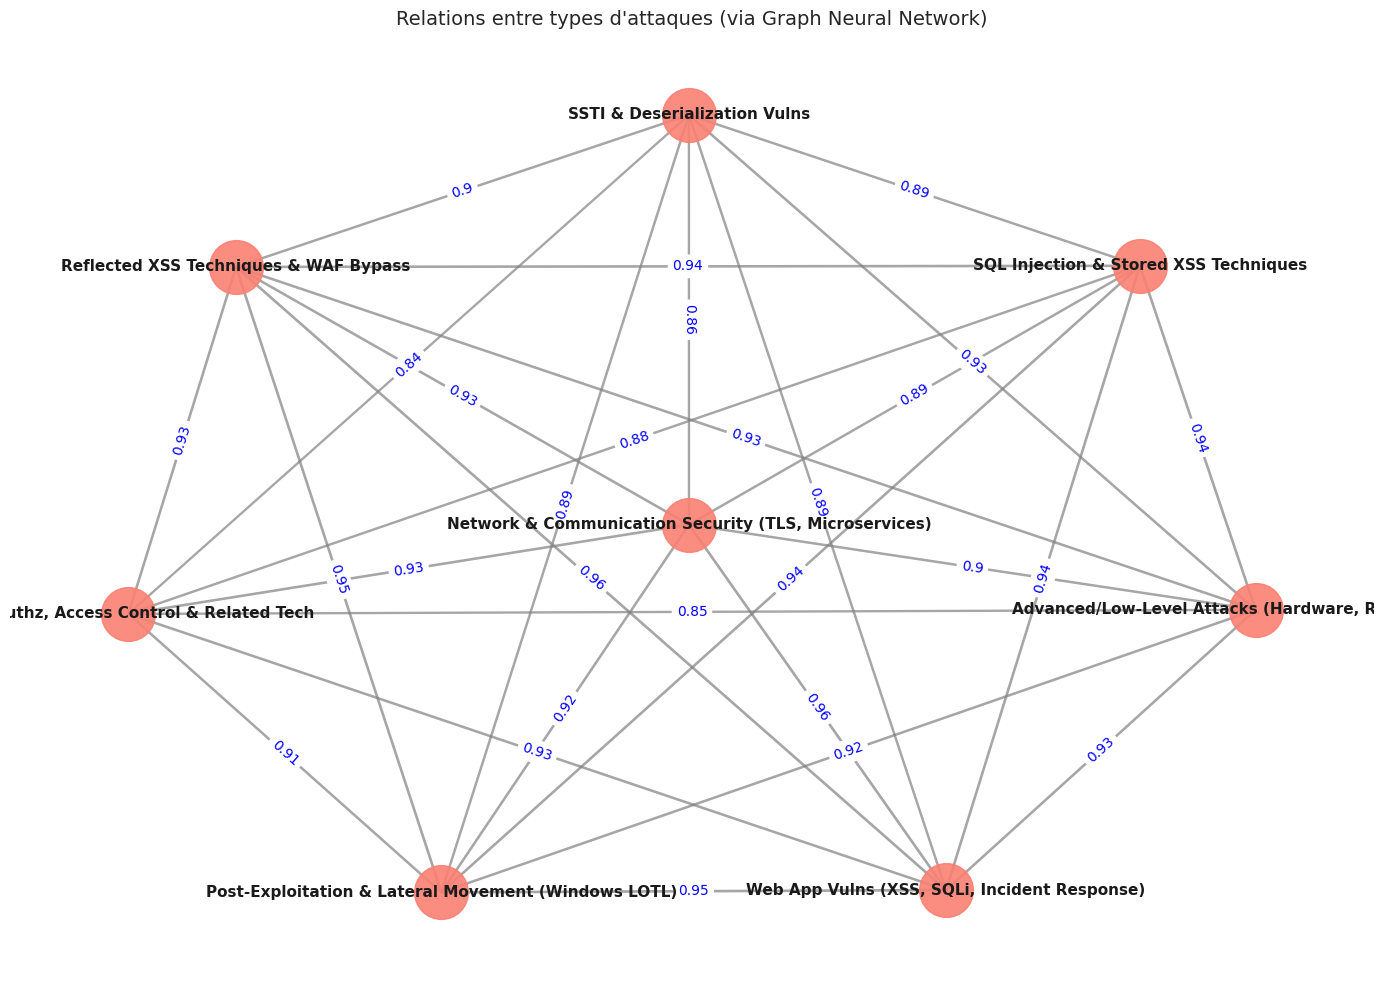


🔗 Relations sémantiques (via GNN) :

✅ 'SSTI & Deserialization Vulns' —— 0.9300000071525574 —— 'Advanced/Low-Level Attacks (Hardware, Rootkits, MITM)'
✅ 'SSTI & Deserialization Vulns' —— 0.8899999856948853 —— 'Post-Exploitation & Lateral Movement (Windows LOTL)'
✅ 'SSTI & Deserialization Vulns' —— 0.8399999737739563 —— 'Auth, Authz, Access Control & Related Tech'
✅ 'SSTI & Deserialization Vulns' —— 0.8899999856948853 —— 'SQL Injection & Stored XSS Techniques'
✅ 'SSTI & Deserialization Vulns' —— 0.8999999761581421 —— 'Reflected XSS Techniques & WAF Bypass'
✅ 'SSTI & Deserialization Vulns' —— 0.8899999856948853 —— 'Web App Vulns (XSS, SQLi, Incident Response)'
✅ 'SSTI & Deserialization Vulns' —— 0.8600000143051147 —— 'Network & Communication Security (TLS, Microservices)'
✅ 'Advanced/Low-Level Attacks (Hardware, Rootkits, MITM)' —— 0.9200000166893005 —— 'Post-Exploitation & Lateral Movement (Windows LOTL)'
✅ 'Advanced/Low-Level Attacks (Hardware, Rootkits, MITM)' —— 0.8500000238418579 —

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# 1. Calculer la similarité cosinus entre les embeddings enrichis
sim_matrix = cosine_similarity(enriched_attack_embs.cpu().numpy())  # [8, 8]

# 2. Créer le graphe
G = nx.Graph()
threshold = 0.5  # ajuste si tu veux plus ou moins de liens

# Ajouter les nœuds
for label in attack_labels:
    G.add_node(label)

# Ajouter les arêtes si similarité > seuil
for i in range(len(attack_labels)):
    for j in range(i + 1, len(attack_labels)):
        sim = sim_matrix[i, j]
        if sim > threshold:
            G.add_edge(
                attack_labels[i],
                attack_labels[j],
                similarity=round(sim, 2)
            )

# 3. Visualiser
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42, k=1.2)

# Nœuds
nx.draw_networkx_nodes(G, pos, node_color='salmon', node_size=1500, alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold')

# Arêtes
edge_weights = [G[u][v]['similarity'] * 2 for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.7, edge_color='gray')

# Labels sur les arêtes
edge_labels = nx.get_edge_attributes(G, 'similarity')
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_color='blue', font_size=10)

plt.title("Relations entre types d'attaques (via Graph Neural Network)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

# 4. Afficher les relations dans la console
print("\n🔗 Relations sémantiques (via GNN) :\n")
for u, v, data in G.edges(data=True):
    print(f"✅ '{u}' —— {data['similarity']} —— '{v}'")

In [ ]:
import torch
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from torch_geometric.data import HeteroData
from torch_geometric.nn import HANConv

print("🚀 Démarrage du pipeline de graphe comportemental...")

# -------------------------------------------------
# 1. Préparer les données propres
# -------------------------------------------------
# Nettoyer et réinitialiser l'index (clé contre KeyError)
df_clean = df.dropna(subset=['sbert_cluster_label', 'user_clean', 'assistant_clean']).copy()
df_clean = df_clean.reset_index(drop=True)  # 🔑 ESSENTIEL
print(f"✅ Données propres : {len(df_clean)} lignes")

# Unifier le type des labels d'attaque (éviter str/int)
df_clean['sbert_cluster_label'] = df_clean['sbert_cluster_label'].astype(str)

# -------------------------------------------------
# 2. Encoder les textes avec Sentence-BERT
# -------------------------------------------------
sbert = SentenceTransformer('all-MiniLM-L6-v2')
print("🔄 Encodage des messages utilisateur...")
user_embs = torch.tensor(sbert.encode(df_clean['user_clean'].tolist()), dtype=torch.float)
print("🔄 Encodage des réponses de l'assistant...")
assistant_embs = torch.tensor(sbert.encode(df_clean['assistant_clean'].tolist()), dtype=torch.float)
print(f"✅ Embeddings générés : {user_embs.shape}, {assistant_embs.shape}")

# -------------------------------------------------
# 3. Préparer les types d'attaques
# -------------------------------------------------
attack_labels = df_clean['sbert_cluster_label'].unique()
attack_to_id = {label: i for i, label in enumerate(attack_labels)}
C = len(attack_labels)
print(f"✅ {C} types d'attaques trouvés")

# Calculer embeddings moyens par attaque
attack_embs = torch.zeros(C, 384)
for label in attack_labels:
    idx = attack_to_id[label]
    mask = df_clean['sbert_cluster_label'] == label
    attack_embs[idx] = user_embs[mask].mean(dim=0)

# -------------------------------------------------
# 4. Clusteriser les comportements de l'assistant
# -------------------------------------------------
print("🔄 Clusterisation des comportements (réponses de l'assistant)...")
clustering = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.7,
    metric='cosine',
    linkage='average'
)
behavior_labels_raw = clustering.fit_predict(assistant_embs.numpy())

# 🔑 Remappage SÛR en [0, 1, ..., B-1]
unique_raw = np.unique(behavior_labels_raw)
behavior_to_contiguous = {raw: i for i, raw in enumerate(unique_raw)}
behavior_labels = np.array([behavior_to_contiguous[raw] for raw in behavior_labels_raw])
num_behaviors = len(unique_raw)
print(f"✅ {num_behaviors} comportements identifiés")

# Embeddings moyens par comportement
behavior_embs = torch.zeros(num_behaviors, 384)
for b_id in range(num_behaviors):
    mask = behavior_labels == b_id
    if mask.sum() > 0:
        behavior_embs[b_id] = assistant_embs[mask].mean(dim=0)


🚀 Démarrage du pipeline de graphe comportemental...
✅ Données propres : 2408 lignes
🔄 Encodage des messages utilisateur...
🔄 Encodage des réponses de l'assistant...
✅ Embeddings générés : torch.Size([2408, 384]), torch.Size([2408, 384])
✅ 8 types d'attaques trouvés
🔄 Clusterisation des comportements (réponses de l'assistant)...
✅ 71 comportements identifiés


In [ ]:
# -------------------------------------------------
# 5. Construire le graphe hétérogène
# -------------------------------------------------
data = HeteroData()

# Nœuds
data['attack_type'].x = attack_embs      # [C, 384]
data['behavior'].x = behavior_embs       # [B, 384]

# Arêtes : attack_type → behavior
edge_index = []
for i in range(len(df_clean)):
    a_label = df_clean.iloc[i]['sbert_cluster_label']
    a_id = attack_to_id[a_label]
    b_id = behavior_labels[i]  # ✅ tableau numpy remappé
    edge_index.append([a_id, b_id])

edge_index = torch.tensor(edge_index).t().contiguous()
data['attack_type', 'triggers', 'behavior'].edge_index = edge_index
print(f"✅ Graphe construit : {C} attaques, {num_behaviors} comportements, {edge_index.size(1)} arêtes")


✅ Graphe construit : 8 attaques, 71 comportements, 2408 arêtes


In [ ]:
# -------------------------------------------------
# 6. Modèle GTN (HANConv)
# -------------------------------------------------
class BehaviorGTN(torch.nn.Module):
    def __init__(self, metadata, hidden_dim=128):
        super().__init__()
        self.conv = HANConv(
            in_channels={'attack_type': 384, 'behavior': 384},
            out_channels=hidden_dim,
            metadata=metadata,
            heads=4
        )
    def forward(self, x_dict, edge_index_dict):
        return self.conv(x_dict, edge_index_dict)['attack_type']
# Auto-boucles pour les nœuds attack_type
num_attacks = attack_embs.size(0)
self_loop = torch.arange(num_attacks).repeat(2, 1)
data['attack_type', 'self', 'attack_type'].edge_index = self_loop
model = BehaviorGTN(data.metadata(), hidden_dim=128)

# Forward (pas d'entraînement)
with torch.no_grad():
    enriched_attack_embs = model(data.x_dict, data.edge_index_dict)
print("✅ Embeddings enrichis par comportement :", enriched_attack_embs.shape)

✅ Embeddings enrichis par comportement : torch.Size([8, 128])


In [ ]:
# -------------------------------------------------
# 7. Créer et visualiser le graphe de relations
# -------------------------------------------------
sim_matrix = cosine_similarity(enriched_attack_embs.cpu().numpy())
G = nx.Graph()
threshold = 0.5

for label in attack_labels:
    G.add_node(label)

for i in range(len(attack_labels)):
    for j in range(i + 1, len(attack_labels)):
        if sim_matrix[i, j] > threshold:
            G.add_edge(attack_labels[i], attack_labels[j], similarity=round(sim_matrix[i, j], 2))

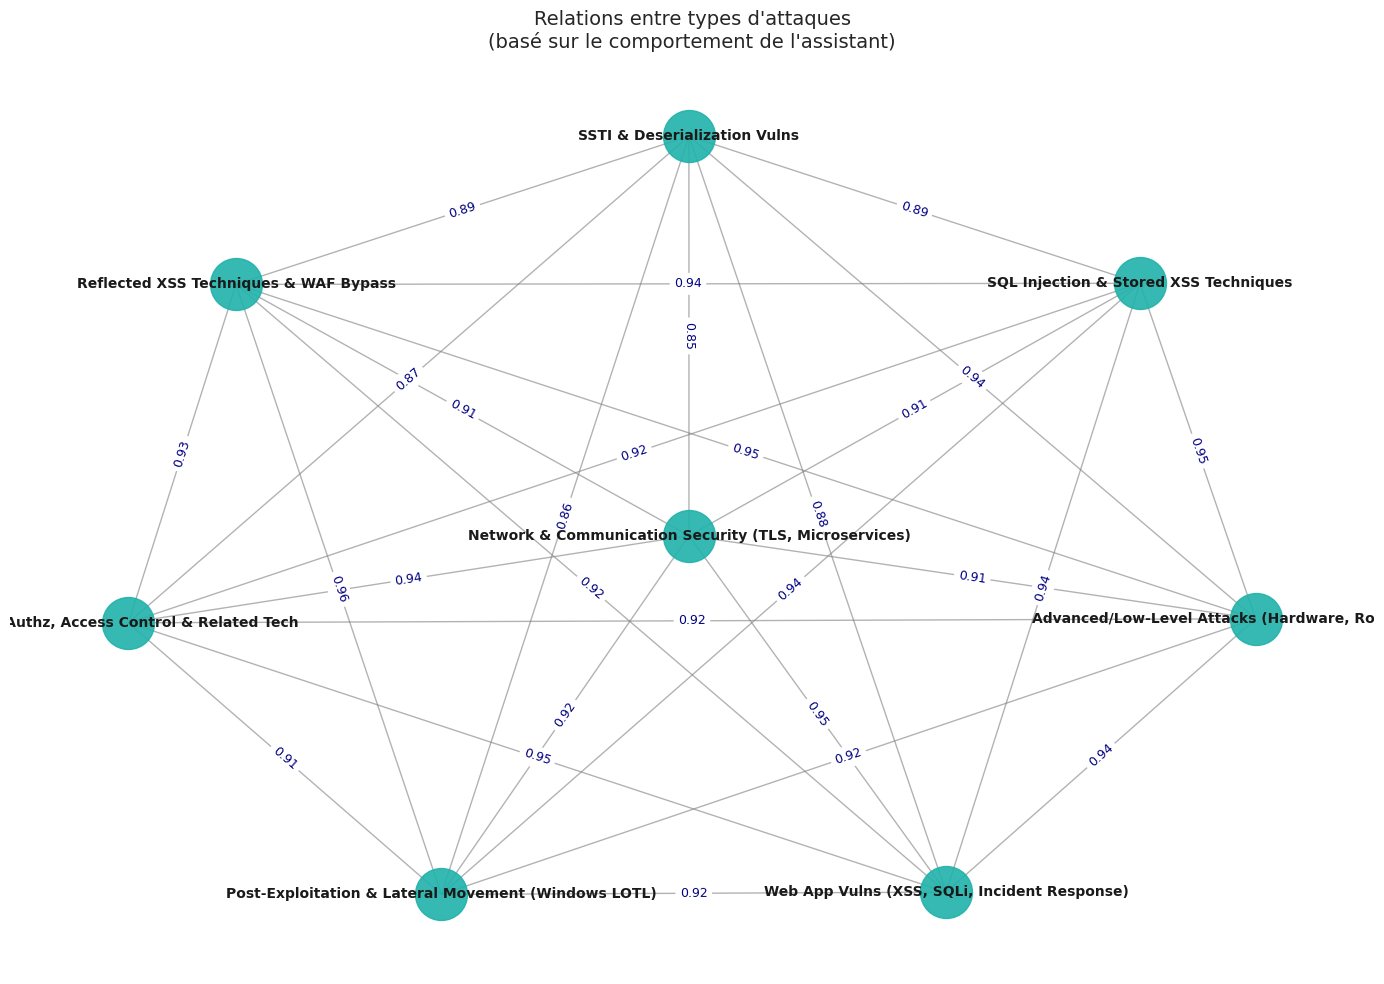


🔗 Relations comportementales trouvées :

✅ 'SSTI & Deserialization Vulns' —— 0.9399999976158142 —— 'Advanced/Low-Level Attacks (Hardware, Rootkits, MITM)'
✅ 'SSTI & Deserialization Vulns' —— 0.8600000143051147 —— 'Post-Exploitation & Lateral Movement (Windows LOTL)'
✅ 'SSTI & Deserialization Vulns' —— 0.8700000047683716 —— 'Auth, Authz, Access Control & Related Tech'
✅ 'SSTI & Deserialization Vulns' —— 0.8899999856948853 —— 'SQL Injection & Stored XSS Techniques'
✅ 'SSTI & Deserialization Vulns' —— 0.8899999856948853 —— 'Reflected XSS Techniques & WAF Bypass'
✅ 'SSTI & Deserialization Vulns' —— 0.8799999952316284 —— 'Web App Vulns (XSS, SQLi, Incident Response)'
✅ 'SSTI & Deserialization Vulns' —— 0.8500000238418579 —— 'Network & Communication Security (TLS, Microservices)'
✅ 'Advanced/Low-Level Attacks (Hardware, Rootkits, MITM)' —— 0.9200000166893005 —— 'Post-Exploitation & Lateral Movement (Windows LOTL)'
✅ 'Advanced/Low-Level Attacks (Hardware, Rootkits, MITM)' —— 0.92000001668930

In [ ]:
# Visualisation
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42, k=1.2)
nx.draw_networkx_nodes(G, pos, node_color='lightseagreen', node_size=1400, alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
nx.draw_networkx_edges(G, pos, alpha=0.6, edge_color='gray')

edge_labels = nx.get_edge_attributes(G, 'similarity')
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_color='navy', font_size=9)

plt.title("Relations entre types d'attaques\n(basé sur le comportement de l'assistant)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig("attack_behavior_graph.png", dpi=200, bbox_inches='tight')
plt.show()

# Afficher les relations
print("\n🔗 Relations comportementales trouvées :\n")
for u, v, data_edge in G.edges(data=True):
    print(f"✅ '{u}' —— {data_edge['similarity']} —— '{v}'")

print("\n✅ Pipeline terminé avec succès.")

In [ ]:
# Liste de logiciels/technos fréquents en sécurité
software_keywords = {
    'windows', 'linux', 'tls', 'ssl', 'mysql', 'postgresql', 'apache', 'nginx',
    'docker', 'kubernetes', 'ssh', 'ftp', 'http', 'api', 'jwt', 'oauth',
    'xss', 'sql', 'nosql', 'ldap', 'xml', 'json', 'javascript', 'python'
}

def extract_software(text):
    text_lower = text.lower()
    found = [kw for kw in software_keywords if kw in text_lower]
    return list(set(found)) if found else ["unknown"]

# Appliquer
df_clean['software_targets'] = df_clean['user_clean'].apply(extract_software)

In [ ]:
technique_keywords = {
    'payload', 'injection', 'bypass', 'obfuscation', 'encoding', 'polyglot',
    'csrf', 'clickjacking', 'race condition', 'deserialization', 'ssti',
    'prompt', 'jailbreak', 'delimiter', 'escape', 'reflection'
}

def extract_techniques(text):
    text_lower = text.lower()
    found = [kw for kw in technique_keywords if kw in text_lower]
    return list(set(found)) if found else ["generic"]

df_clean['attack_techniques'] = df_clean['user_clean'].apply(extract_techniques)

In [ ]:
from torch_geometric.data import HeteroData
import torch

data = HeteroData()

# --- Nœuds ---
# attack_type (déjà fait)
data['attack_type'].x = attack_embs  # [C, 384]

# software_target : créer un nœud par logiciel unique
all_software = set()
for targets in df_clean['software_targets']:
    all_software.update(targets)
software_list = sorted(all_software)
software_to_id = {s: i for i, s in enumerate(software_list)}
data['software_target'].x = torch.randn(len(software_list), 384)  # dummy embeddings

# attack_technique
all_techniques = set()
for techs in df_clean['attack_techniques']:
    all_techniques.update(techs)
technique_list = sorted(all_techniques)
technique_to_id = {t: i for i, t in enumerate(technique_list)}
data['attack_technique'].x = torch.randn(len(technique_list), 384)

# response_behavior (déjà fait)
data['response_behavior'].x = behavior_embs  # [B, 384]

# --- Arêtes ---
edges = {}

# attack_type → software_target
edge_list = []
for _, row in df_clean.iterrows():
    a_id = attack_to_id[row['sbert_cluster_label']]
    for sw in row['software_targets']:
        sw_id = software_to_id[sw]
        edge_list.append([a_id, sw_id])
edges[('attack_type', 'targets', 'software_target')] = torch.tensor(edge_list).t()

# attack_type → attack_technique
edge_list = []
for _, row in df_clean.iterrows():
    a_id = attack_to_id[row['sbert_cluster_label']]
    for tech in row['attack_techniques']:
        tech_id = technique_to_id[tech]
        edge_list.append([a_id, tech_id])
edges[('attack_type', 'uses', 'attack_technique')] = torch.tensor(edge_list).t()

# attack_type → response_behavior (déjà fait)
edge_list = []
for i, row in df_clean.iterrows():
    a_id = attack_to_id[row['sbert_cluster_label']]
    b_id = behavior_labels[i]
    edge_list.append([a_id, b_id])
edges[('attack_type', 'triggers', 'response_behavior')] = torch.tensor(edge_list).t()

# Assigner au graphe
for et, ei in edges.items():
    data[et].edge_index = ei

In [ ]:
from torch_geometric.nn import HANConv

class MultiRelationGTN(torch.nn.Module):
    def __init__(self, metadata, hidden_dim=128):
        super().__init__()
        self.conv = HANConv(
            in_channels={
                'attack_type': 384,
                'software_target': 384,
                'attack_technique': 384,
                'response_behavior': 384
            },
            out_channels=hidden_dim,
            metadata=metadata,
            heads=4
        )
    def forward(self, x_dict, edge_index_dict):
        return self.conv(x_dict, edge_index_dict)['attack_type']

model = MultiRelationGTN(data.metadata(), hidden_dim=128)

with torch.no_grad():
    enriched = model(data.x_dict, data.edge_index_dict)

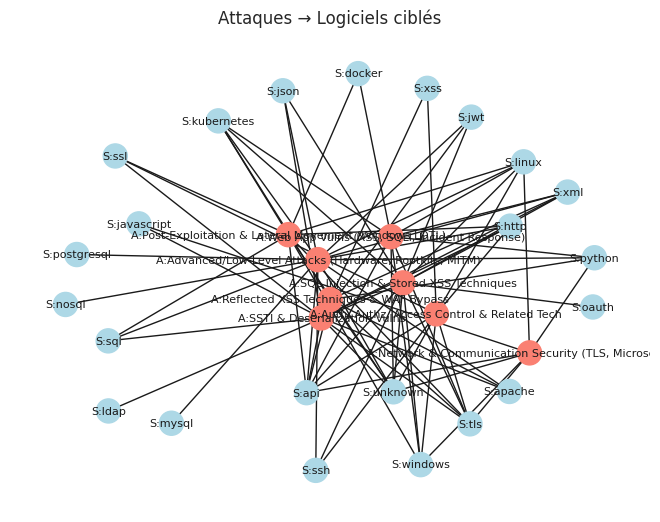

In [ ]:
G = nx.Graph()
for a in attack_labels:
    G.add_node(f"A:{a}", color='salmon')
for s in software_list:
    G.add_node(f"S:{s}", color='lightblue')

for (src, rel, dst), ei in edges.items():
    if rel == 'targets':
        for a_id, s_id in ei.t().numpy():
            G.add_edge(f"A:{attack_labels[a_id]}", f"S:{software_list[s_id]}")

# Visualiser
pos = nx.spring_layout(G, k=1.7)
colors = [G.nodes[n]['color'] for n in G.nodes()]
nx.draw(G, pos, node_color=colors, with_labels=True, font_size=8)
plt.title("Attaques → Logiciels ciblés")
plt.show()

/tmp/ipython-input-2936704423.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


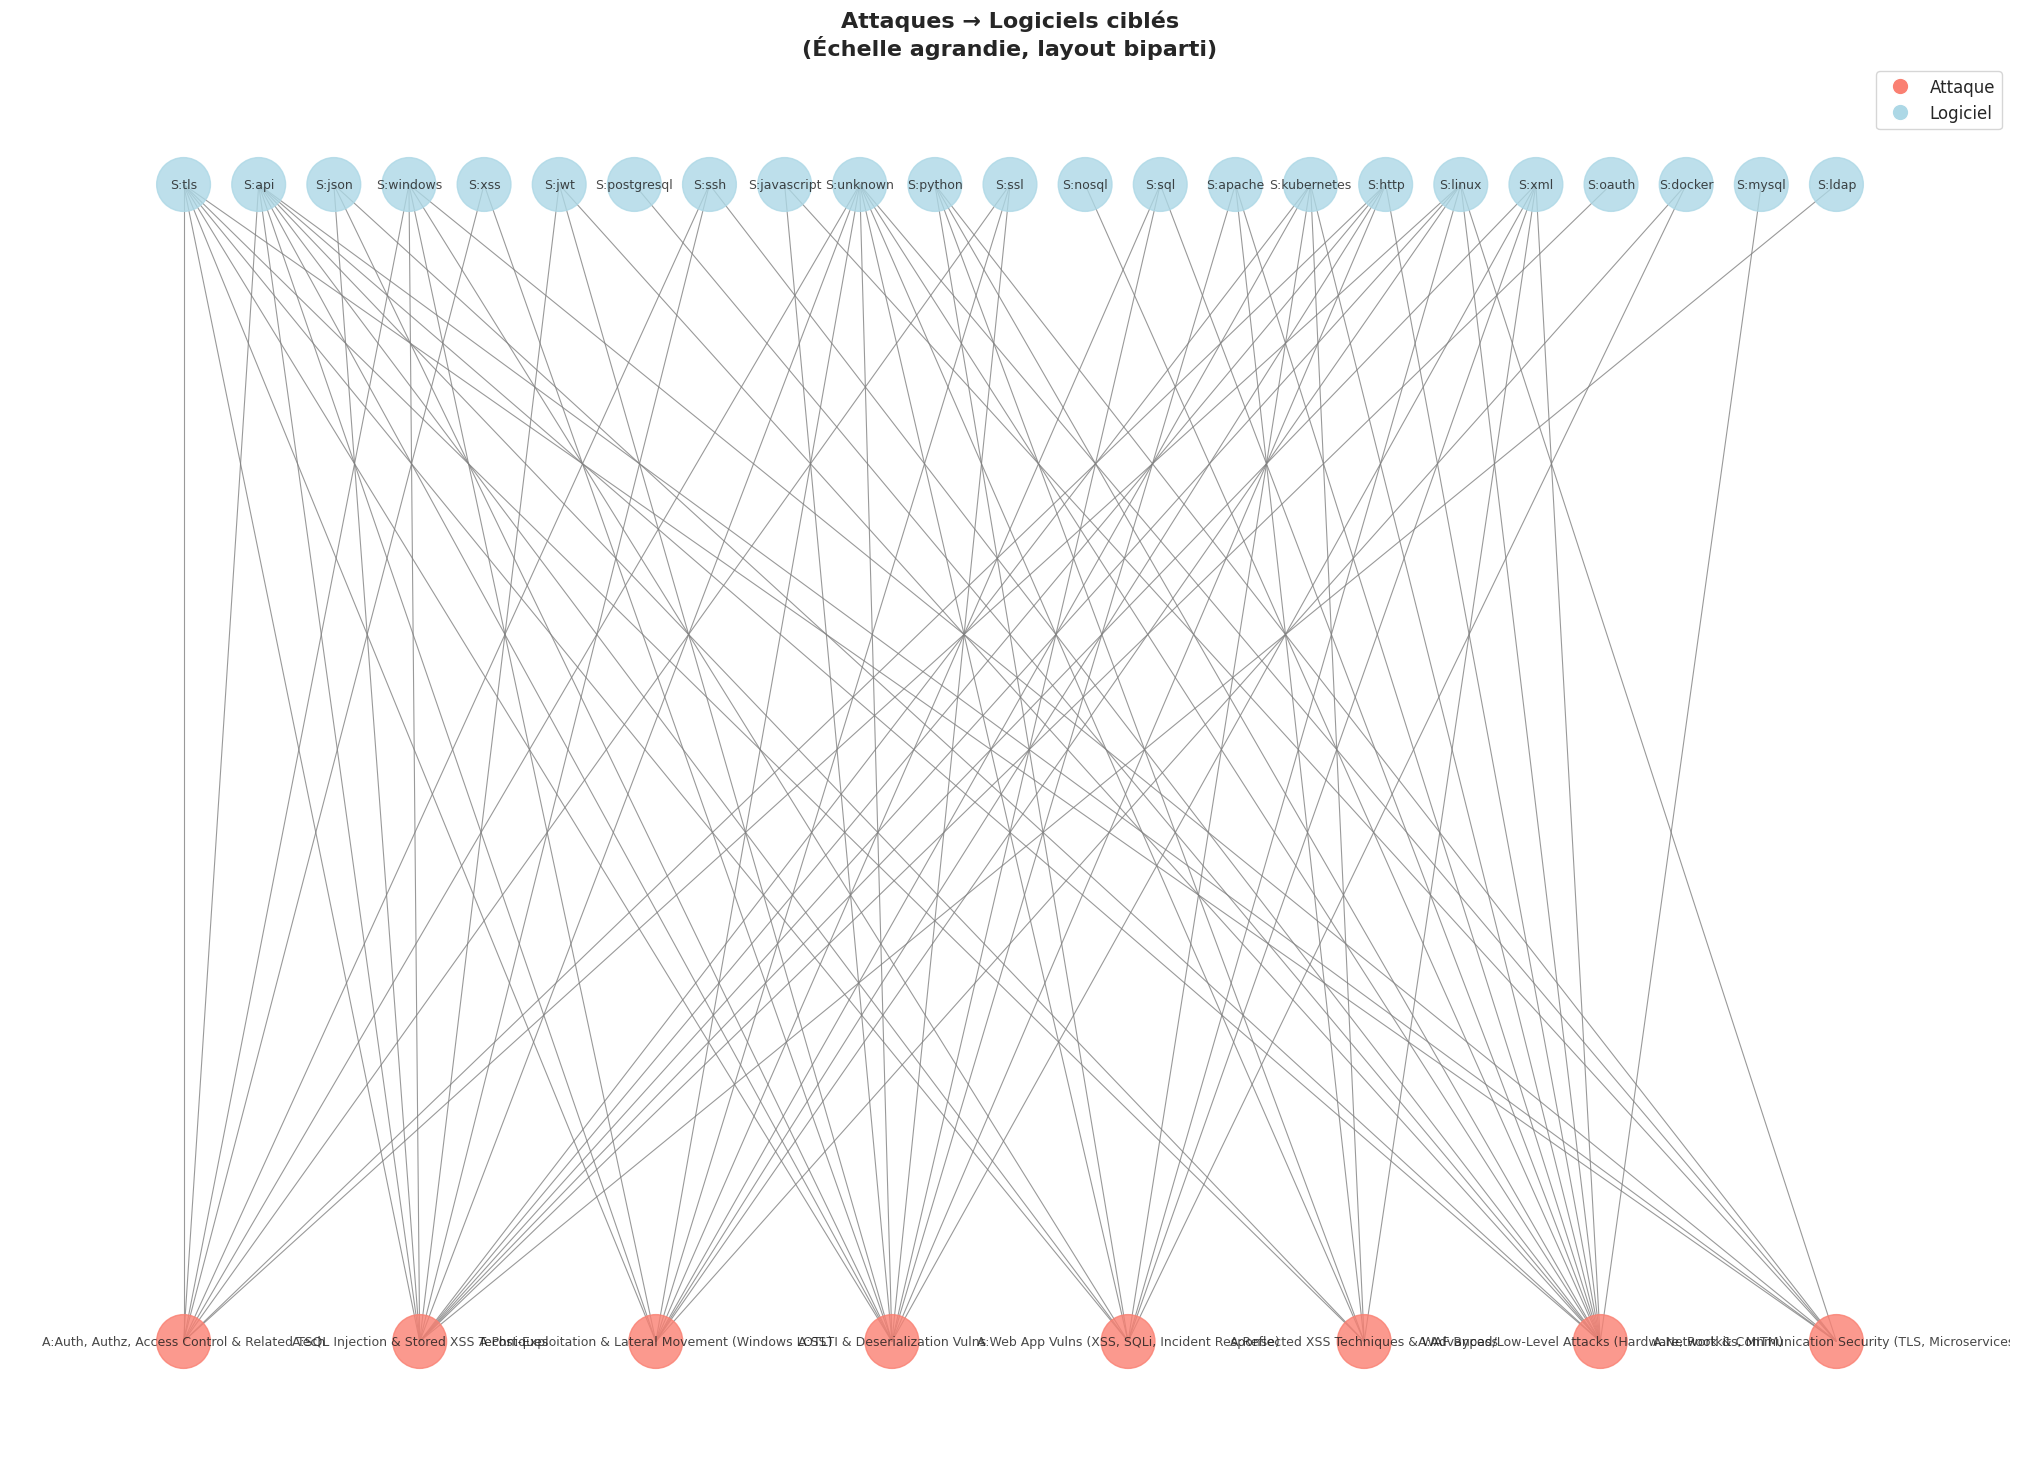

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Créer le graphe biparti
G = nx.Graph()

# Ajouter les nœuds avec préfixe
for a in attack_labels:
    G.add_node(f"A:{a}", type='attack', color='salmon')
for s in software_list:
    G.add_node(f"S:{s}", type='software', color='lightblue')

# Ajouter les arêtes (relation 'targets')
edge_type = ('attack_type', 'targets', 'software_target')
if edge_type in data.edge_index_dict:
    edge_index = data[edge_type].edge_index.numpy()
    for i in range(edge_index.shape[1]):
        a_id = edge_index[0, i]
        s_id = edge_index[1, i]
        G.add_edge(f"A:{attack_labels[a_id]}", f"S:{software_list[s_id]}")
else:
    raise ValueError("Relation 'targets' non trouvée.")

# 🎯 Layout biparti + échelle augmentée
attack_nodes = [n for n in G.nodes() if n.startswith("A:")]
software_nodes = [n for n in G.nodes() if n.startswith("S:")]

# Utiliser un layout biparti avec plus d'espace
pos = nx.bipartite_layout(G, attack_nodes, align='horizontal', scale=3)  # ⬆️ scale=3 → plus d'espace

# Couleurs
node_colors = [G.nodes[n]['color'] for n in G.nodes()]

# 🖼️ Dessiner avec des paramètres de taille augmentée
plt.figure(figsize=(20, 14))  # 👈 Plus grand canvas

nx.draw(
    G, pos,
    node_color=node_colors,
    node_size=1500,          # 👈 Plus gros nœuds
    font_size=9,             # 👈 Texte plus lisible
    with_labels=True,
    edge_color='gray',
    alpha=0.8,
    width=0.8                # 👈 Arêtes plus fines
)

# 💡 Ajouter une légende pour distinguer les types
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Attaque', markerfacecolor='salmon', markersize=12),
    plt.Line2D([0], [0], marker='o', color='w', label='Logiciel', markerfacecolor='lightblue', markersize=12)
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.title("Attaques → Logiciels ciblés\n(Échelle agrandie, layout biparti)", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig("subgraph_attacks_to_software_enlarged.png", dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
selected_attacks = [
    "Reflected XSS Techniques & WAF Bypass",
    "SQL Injection & Stored XSS Techniques",
    "Post-Exploitation & Lateral Movement (Windows LOTL)"
]

/tmp/ipython-input-2953135361.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


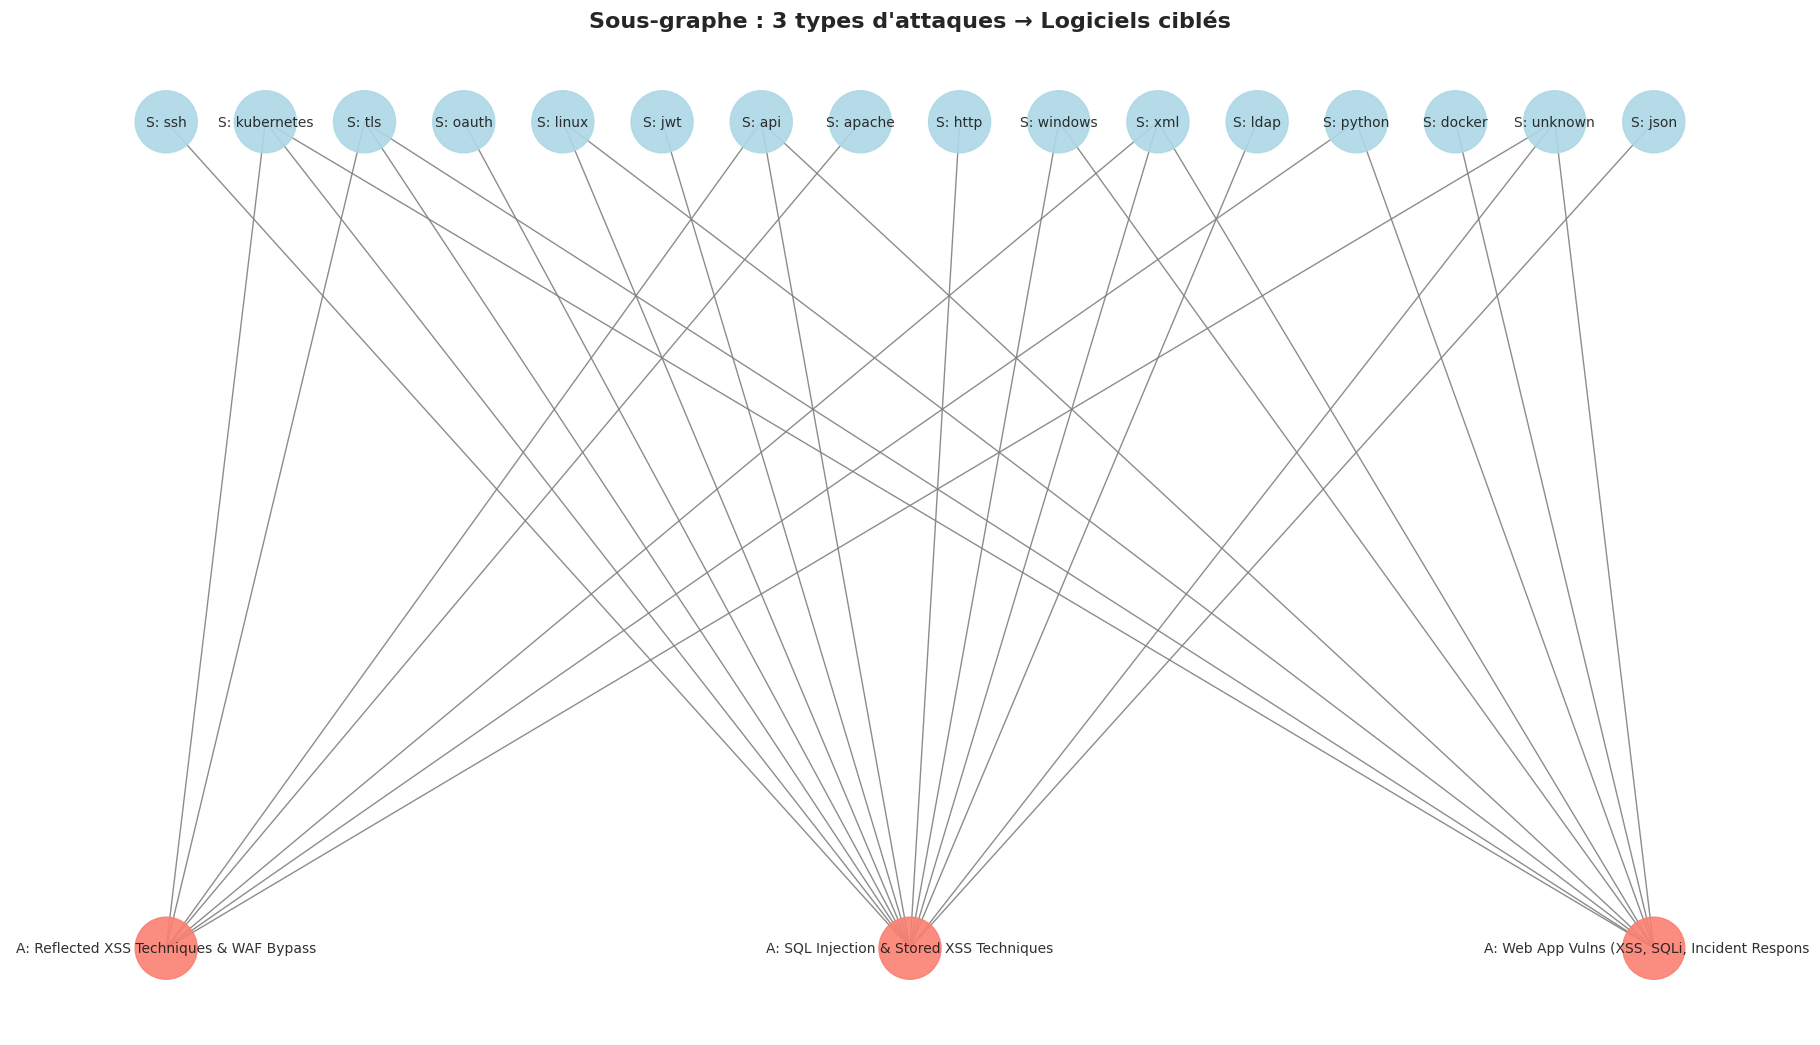

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# 🔹 Choisis ici tes 3 attaques (remplace par les tiennes si besoin)
selected_attacks = [
    "Reflected XSS Techniques & WAF Bypass",
    "SQL Injection & Stored XSS Techniques",
    "Web App Vulns (XSS, SQLi, Incident Response)"
]

# Vérifier que les attaques existent
for a in selected_attacks:
    assert a in attack_labels, f"Attaque non trouvée : {a}"

# 🔹 Créer le sous-graphe filtré
G = nx.Graph()

# Ajouter uniquement les 3 attaques choisies
for a in selected_attacks:
    G.add_node(f"A: {a}", type='attack', color='salmon')

# Récupérer les logiciels liés à ces attaques
software_set = set()
edge_type = ('attack_type', 'targets', 'software_target')
if edge_type not in data.edge_index_dict:
    raise ValueError("Relation 'targets' non trouvée.")

edge_index = data[edge_type].edge_index.numpy()
attack_to_id_inv = {v: k for k, v in attack_to_id.items()}

for i in range(edge_index.shape[1]):
    a_id = edge_index[0, i]
    s_id = edge_index[1, i]
    attack_name = attack_to_id_inv[a_id]
    if attack_name in selected_attacks:
        software_name=software_list[s_id]
        software_set.add(software_name)
        G.add_edge(f"A: {attack_name}", f"S: {software_name}")

# Ajouter les nœuds logiciels
for s in software_set:
    G.add_node(f"S: {s}", type='software', color='lightblue')

# 🔹 Layout biparti agrandi
attack_nodes = [n for n in G.nodes() if n.startswith("A:")]
pos = nx.bipartite_layout(G, attack_nodes, align='horizontal', scale=3)

# Couleurs
node_colors = [G.nodes[n]['color'] for n in G.nodes()]

# 🔹 Visualiser
plt.figure(figsize=(18, 10))
nx.draw(
    G, pos,
    node_color=node_colors,
    node_size=2000,
    font_size=10,
    with_labels=True,
    edge_color='gray',
    alpha=0.9,
    width=1.0
)

plt.title("Sous-graphe : 3 types d'attaques → Logiciels ciblés", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig("subgraph_3_attacks.png", dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
pip install gradio pandas sentence-transformers faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 17.2 MB/s eta 0:00:00


# **Q&A**

In [ ]:
import gradio as gr
import pandas as pd
import re
import string
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
from transformers import MarianMTModel, MarianTokenizer

# ----------------------------
# 1. Charger et filtrer le dataset
# ----------------------------
df = pd.read_csv("cybersecurity_dataset.csv", encoding='utf-8', low_memory=False)

def is_clean_answer(text):
    if pd.isna(text):
        return False
    text = str(text).strip()
    if len(text) < 100:
        return False
    bad_starters = ["The user", "<think>", "Okay,", "This is a", "Let me", "I think", "Sure!", "Certainly", "Hello"]
    if any(starter in text[:150] for starter in bad_starters):
        return False
    tech_words = ["vulnerability", "attack", "exploit", "payload", "CVE", "XSS", "RCE", "deserialization", "SSTI", "prototype pollution", "CSRF"]
    return any(word in text.lower() for word in tech_words)

df_clean = df[
    df["user"].notna() &
    df["assistant"].notna() &
    df["assistant"].apply(is_clean_answer)
][["user", "assistant"]].drop_duplicates().reset_index(drop=True)

print(f"✅ {len(df_clean)} paires QA chargées.")

# ----------------------------
# 2. Prétraitement et construction de l'index FAISS
# ----------------------------
def normalize_text(text):
    text = text.lower().strip()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text

model = SentenceTransformer('all-MiniLM-L6-v2')

questions = [normalize_text(q) for q in df_clean["user"].tolist()]
answers = df_clean["assistant"].tolist()

q_embs = model.encode(questions)
faiss.normalize_L2(q_embs)

index = faiss.IndexFlatIP(384)
index.add(q_embs.astype("float32"))

THRESHOLD = 0.40  # Niveau de similarité minimale

# ----------------------------
# 3. Détection simple de texte français
# ----------------------------
COMMON_FRENCH_WORDS = {
    "le", "la", "les", "un", "une", "des", "que", "qui", "quoi", "comment",
    "pourquoi", "où", "est", "ce", "cette", "dans", "sur", "de", "du",
    "en", "avec", "sans", "ne", "pas", "je", "tu", "il", "elle", "nous",
    "vous", "ils", "elles", "quel", "quelle", "quelles", "quels", "si",
    "et", "au", "aux", "ses", "son", "sa", "leurs", "leur", "pour"
}

def looks_like_french(text):
    tokens = re.findall(r"[a-zàâçéèêëîïôûùüÿñæœ]+", text.lower())
    if len(tokens) < 1:
        return False
    french_hits = sum(1 for t in tokens if t in COMMON_FRENCH_WORDS)
    ratio = french_hits / len(tokens)
    return ratio > 0.2 or len(tokens) >= 2

# ----------------------------
# 4. Récupération de la réponse (per-token)
# ----------------------------
def get_direct_answer(question: str):
    tokens = re.findall(r"[a-zA-Z0-9àâçéèêëîïôûùüÿñæœ]+", question)
    best_score = 0
    best_idx = -1

    for token in tokens:
        token_norm = normalize_text(token)
        emb = model.encode([token_norm])
        faiss.normalize_L2(emb)
        scores, idxs = index.search(emb.astype("float32"), k=1)
        if scores[0][0] > best_score:
            best_score = scores[0][0]
            best_idx = idxs[0][0]

    if best_score < THRESHOLD:
        return None, best_score

    return answers[best_idx], best_score

# ----------------------------
# 5. Summarisation et amélioration UX
# ----------------------------
def summarize_answer(answer, question, max_sentences=3):
    sentences = re.split(r'(?<=[.!?]) +', answer)

    seen = set()
    unique_sentences = []
    for s in sentences:
        if s not in seen:
            unique_sentences.append(s)
            seen.add(s)

    question_tokens = set(re.findall(r"\w+", question.lower()))
    def sentence_score(s):
        s_tokens = set(re.findall(r"\w+", s.lower()))
        return len(s_tokens & question_tokens)

    scored_sentences = sorted(unique_sentences, key=sentence_score, reverse=True)

    # Highlight steps
    step_pattern = re.compile(r'(step \d+|first|second|then|finally)', re.IGNORECASE)
    highlighted_sentences = []
    for s in scored_sentences[:max_sentences]:
        if step_pattern.search(s):
            highlighted_sentences.append("🔹 " + s)
        else:
            highlighted_sentences.append(s)

    return " ".join(highlighted_sentences)

# ----------------------------
# 6. Translation model (EN → FR)
# ----------------------------
translation_model_name = "Helsinki-NLP/opus-mt-en-fr"
translation_tokenizer = MarianTokenizer.from_pretrained(translation_model_name)
translation_model = MarianMTModel.from_pretrained(translation_model_name)

def translate_to_french(text):
    translated = translation_model.generate(**translation_tokenizer(text, return_tensors="pt", padding=True))
    fr_text = translation_tokenizer.decode(translated[0], skip_special_tokens=True)
    return fr_text

# ----------------------------
# 7. Interface Gradio (predict)
# ----------------------------
def predict(question):
    if not question or re.fullmatch(r"\s*", question):
        return "Posez votre question en cybersécurité..."

    try:
        answer, score = get_direct_answer(question)

        if answer is None:
            return "Je n’ai pas trouvé de réponse pertinente à votre question."

        if score >= THRESHOLD and not looks_like_french(question):
            return "Je n’ai pas trouvé de réponse pertinente à votre question."

        # Summarize and highlight steps
        short_answer = summarize_answer(answer, question, max_sentences=3)

        # Translate to French
        short_answer_fr = translate_to_french(short_answer)
        return short_answer_fr

    except Exception as e:
        print(f"[ERREUR] {e}")
        return "Désolé, je n’ai pas pu trouver de réponse dans la base de connaissances."

# ----------------------------
# 8. Lancer l'interface
# ----------------------------
description = """
🔍 **Chatbot spécialisé en cybersécurité**
Posez des questions techniques sur les vulnérabilités, les attaques, les mécanismes de défense, etc.
Les réponses proviennent d’un corpus expert.
"""

examples = [
    ["Quelle vulnérabilité affecte Express.js ?"],

    ["Qu'est-ce que le SSTI ?"],
    ["Comment prévenir le XSS DOM ?"],
    ["Un attaquant utilise un Open Redirect pour faire du SSRF. Comment ?"],
    ["Pourquoi un champ de recherche peut-il devenir une cible CSRF ?"]
]

gr.Interface(
    fn=predict,
    inputs=gr.Textbox(
        lines=2,
        placeholder="Posez votre question en cybersécurité...",
        label="Votre question"
    ),
    outputs=gr.Textbox(
        label="Réponse",
        lines=8,
        max_lines=20,
        interactive=False
    ),
    title="🛡️ Cyber-RAG – Assistant en sécurité offensive/défensive",
    description=description,
    examples=examples,
    theme="soft"
).launch(share=True)


✅ 1686 paires QA chargées.


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()


model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

* Running on public URL: https://d5710c0d8cacaeac47.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
